In [8]:
import pandas as pd
import polars as pl
import numpy as np
from reliability.Fitters import Fit_Everything
from joblib import Parallel, delayed
from pathlib import Path
from dateutil.relativedelta import relativedelta
import os
from urllib.request import urlopen, urlretrieve
import warnings
from tqdm import tqdm
import os
from datetime import date

pd.set_option('display.max_columns', None)

In [3]:
# Dados disponíveis em: https://dadosabertos.aneel.gov.br/dataset/interrupcoes-de-energia-eletrica-nas-redes-de-distribuicao
dict_filenames = {'intrp_2017': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/246e926b-a686-42fc-b55f-32e4046834de/download/interrupcoes-energia-eletrica-2017.csv',
                  'intrp_2018': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/8fcce0f2-4ea2-42ea-b7ac-00fd8feab03c/download/interrupcoes-energia-eletrica-2018.csv',
                  'intrp_2019': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/965d2abb-91fe-4fab-b463-8c84f2e02188/download/interrupcoes-energia-eletrica-2019.csv',
                  'intrp_2020': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/58201617-8364-4e7f-975d-21f8b8c7436f/download/interrupcoes-energia-eletrica-2020.csv',
                  'intrp_2021': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/42d778de-4a10-4b54-a00a-87c8ff35db6f/download/interrupcoes-energia-eletrica-2021.csv',
                  'intrp_2022': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/7d081751-3f4c-4ede-96b5-1bf2e46b61ca/download/interrupcoes-energia-eletrica-2022.csv',
                  'intrp_2023': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/cce72c2b-a4cb-4b98-818f-3ac56bbf2a78/download/interrupcoes-energia-eletrica-2023.csv',
                  'intrp_2024': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/cc091bb8-b308-46b2-98ec-c2fd58e7194b/download/interrupcoes-energia-eletrica-2024.csv',
                 }

In [4]:
# Pasta onde serão armazenados os dados
folder='./dados2/'
try:
    os.mkdir(folder)
except:
    pass

# Define a lista de CSV já baixado
ls_csv = [i.split('.csv')[0] for i in os.listdir(folder) if i.endswith('.csv')]

# Somente os arquivos não baixados
filenames_new = dict_filenames.keys() - ls_csv
dict_filenames_new = {k:dict_filenames[k] for k in filenames_new}

# Faz o download dos dataset
pbar = tqdm(dict_filenames_new.items())
for i in pbar:
    pbar.set_description(f"Downloading {i[0]}")
    urlretrieve(i[1], folder+i[0]+'.csv')

0it [00:00, ?it/s]


# Importação dos dados

In [668]:
# Converte em parquet
col_dtypes = {'DatGeracaoConjuntoDados': 'string',
              'IdeConjuntoUnidadeConsumidora': 'Int64',
              'DscConjuntoUnidadeConsumidora': 'string',
              'DscAlimentadorSubestacao': 'string',
              'DscSubestacaoDistribuicao': 'string',
              'NumOrdemInterrupcao': 'string',
              'DscTipoInterrupcao': 'string',
              'IdeMotivoInterrupcao': 'Int64',
              'DatInicioInterrupcao': 'string',
              'DatFimInterrupcao': 'string',
              'DscFatoGeradorInterrupcao': 'string',
              'NumNivelTensao': 'Int64',
              'NumUnidadeConsumidora': 'Int64',
              'NumConsumidorConjunto': 'Int64',
              'NumAno': 'Int64',
              'NomAgenteRegulado': 'string',
              'SigAgente': 'string',
              'NumCPFCNPJ': 'Int64'}

def intrp_to_parquet(filename, col_dtypes=col_dtypes):
    filename_core = filename.split('.csv')[-2]
    
    df_intrp = pd.read_csv(filename, sep=';', decimal=',', 
                           encoding='ISO-8859-1')
    # Formatação das colunas
    df_intrp['NumCPFCNPJ'] = pd.to_numeric(df_intrp['NumCPFCNPJ'], errors='coerce')
    df_intrp = df_intrp.astype(col_dtypes)
    df_intrp['DatGeracaoConjuntoDados'] = pd.to_datetime(df_intrp['DatGeracaoConjuntoDados'])
    df_intrp['DatInicioInterrupcao'] = pd.to_datetime(df_intrp['DatInicioInterrupcao'])
    df_intrp['DatFimInterrupcao'] = pd.to_datetime(df_intrp['DatFimInterrupcao'])
    
    df_intrp.dropna().to_parquet(f'{filename_core}.parquet')

In [6]:
# Define a lista de PARQUET já criados
ls_parquet = [i.split('.parquet')[0] for i in os.listdir(folder) if i.endswith('.parquet')]
# Lista os arquivos que tem CSV e não tem PARQUET
ls_filenames = [f"{folder}{file}"+'.csv' for file in set(ls_csv) - set(ls_parquet)]
# Converte em Parquet
_ = [intrp_to_parquet(filename) for filename in tqdm(ls_filenames)]

0it [00:00, ?it/s]


In [7]:
# Atualiza o ano corrente
# intrp_to_parquet('dados/intrp_2024.csv')

In [8]:
# Concatena todos os parquets
ls_df = [pl.scan_parquet(folder+file+'.parquet').select(col_dtypes.keys()) for file in ls_parquet]

In [9]:
df = pl.concat(ls_df)

IdeMotivoExpurgo


Identificador referenciando o Motivo do Expurgo.

- 0 - Não houve expurgo
- 1 - Falha nas instalações da unidade consumidora que não provoque interrupção em instalações de terceiros
- 2 - Interrupção decorrente de obras de interesse exclusivo do consumidor e que afete somente a unidade consumidora do mesmo
- 3 - Interrupção em situação de emergência
- 4 - Suspensão por inadimplemento do consumidor ou por deficiência técnica e/ou de segurança das instalações da unidade consumidora que não provoque interrupção em instalações de terceiros, previstas em regulamentação
- 5 - Vinculadas a programas de racionamento instituídos pela União
- 6 - Ocorridas em dia crítico
- 7 - Oriundas de atuação de esquemas de alívio de carga solicitado pelo ONS
- 8 - Interrupção de origem externa ao sistema de distribuição

In [10]:
# Colunas Auxiliares
df = df.with_columns(pl.col('DatFimInterrupcao').sub(pl.col('DatInicioInterrupcao')).dt.total_minutes().truediv(60).alias('duracao_h'))
df = df.with_columns(pl.col('duracao_h').mul(pl.col('NumUnidadeConsumidora')).alias('chi'))
df = df.with_columns((pl.col('duracao_h') <= 3/60).alias('fm'))
df = df.with_columns(pl.col('DatInicioInterrupcao').cast(pl.Date).alias('DatInicioInterrupcao_date'))
df = df.with_columns(pl.col('SigAgente').str.strip_chars())

In [11]:
# Verifica ISE e DC (exp) do restante (liq)
df_sumchi_dias = df.group_by(['SigAgente', 
                              'IdeConjuntoUnidadeConsumidora', 
                              'DatInicioInterrupcao_date']).agg(pl.col('chi').filter(pl.col('IdeMotivoInterrupcao').is_in([3,6])).sum().alias('chi_exp'),
                                                                pl.col('chi').filter(~pl.col('IdeMotivoInterrupcao').is_in([3,6])).sum().alias('chi_liq'),
                                                                pl.col('chi').sum().alias('chi_tot'),
                                                               )

# Separa os dias em que houve mais expurgo que liq como EXP, senão líquido
df_sumchi_dias = df_sumchi_dias.with_columns(pl.when(pl.col('chi_exp') > pl.col('chi_liq'))\
                                               .then(pl.lit('exp')).otherwise(pl.lit('liq'))\
                                               .alias('tipo'))

df_sumchi_dias = df_sumchi_dias.collect()

In [12]:
# Verifica as datas iniciais e finais de cada conjunto sigagente
df_cea_datas = df_sumchi_dias.group_by(['IdeConjuntoUnidadeConsumidora', 'SigAgente']).agg(dtini = pl.col('DatInicioInterrupcao_date').min(), 
                                                                                           dtfim = pl.col('DatInicioInterrupcao_date').max(),
                                                                                          )#.collect()

# Modifica a data fim quando ela termina no dia 1 do mês. A verificar o porque isso ocorre
df_cea_datas = df_cea_datas.with_columns(pl.when(pl.col('dtfim').dt.day() == 1).then(pl.col('dtfim') + pl.duration(days=-1)).otherwise(pl.col('dtfim')))

In [42]:
# Cria uma pasta com os arquivos auxiliares de saída
path = 'output'
p = Path(path)
p.mkdir(parents=True, exist_ok=True)

In [17]:
# Adiciona os dias sem interrupções com valores de chi 0
for idx, row in tqdm(zip(range(len(df_cea_datas)), df_cea_datas.iter_rows()), total=len(df_cea_datas)):
    cea, sigagente, dtini, dtfim = row

    # Seleciona o slice
    df_cea = df_sumchi_dias.filter((pl.col('SigAgente') == sigagente)
                                   & (pl.col('IdeConjuntoUnidadeConsumidora') == cea)
                                  )
    # Cria range de datas
    df_daterange = pl.DataFrame(pl.date_range(start=dtini.replace(day=1),
                                 end = dtfim.replace(day=1) + relativedelta(months=1, days=-1),
                                 interval='1d',
                                 eager=True
                                ).alias('DatInicioInterrupcao_date'))
    
    # Adiciona as datas sem interrupções ao DF original
    df_cea_full = df_daterange.join(df_cea, on='DatInicioInterrupcao_date', how='left')

    # Preenche os valores nulos as datas sem interrupções
    df_cea_full = df_cea_full.with_columns(pl.col('SigAgente').fill_null(sigagente),
                                           pl.col('IdeConjuntoUnidadeConsumidora').fill_null(cea),
                                           pl.col('chi_exp').fill_null(0.0),
                                           pl.col('chi_liq').fill_null(0.0),
                                           pl.col('chi_tot').fill_null(0.0),
                                           pl.col('tipo').fill_null('liq'),
                                          )

    # Exporta os arquivos a cada 550 iterações
    if idx in range(0,len(df_cea_datas), 500):
        if idx ==0:
            df_sumchi_dias_full = df_cea_full
        else:
            df_sumchi_dias_full.write_parquet(f'{path}/df_sumchi_dias_full_{idx}.parquet')
            df_sumchi_dias_full = df_cea_full
    else:
        df_sumchi_dias_full = pl.concat([df_sumchi_dias_full, df_cea_full])

 23%|██▎       | 901/4000 [00:51<02:57, 17.46it/s]

KeyboardInterrupt



In [ ]:
# Lista os arquivos auxiliares
ls_files = p.glob('**/df_sumchi_dias_full_*.parquet')
files = [x for x in ls_files]

# Concatena os arquivos auxiliares
df_sumchi_dias_full = pl.concat([pl.read_parquet(file) for file in tqdm(files)])
df_sumchi_dias_full.write_parquet(f'{path}/df_sumchi_dias_full.parquet')
# Remove os arquivos auxiliares
_ = [os.remove(file) for file in files]

In [14]:
# Verifica os dias de rescaldos (após o dia exp)
df_sumchi_dias_full = df_sumchi_dias_full.with_columns(pl.when(pl.col('tipo') == 'exp')\
                                                       .then(pl.col('DatInicioInterrupcao_date') + pl.duration(days=1))
                                                       .alias('DatDiaRescaldo'))

In [15]:
# Separa os dias de rescaldo
df_dias_rescaldo = df_sumchi_dias_full.filter(pl.col('DatDiaRescaldo').is_not_null()).select(['SigAgente', 'IdeConjuntoUnidadeConsumidora', 'DatDiaRescaldo'])
# Cria Coluna auxiliar para identificar os dias que devem ser rotulados como rescaldo
df_dias_rescaldo = df_dias_rescaldo.with_columns(pl.lit(True).alias('tag_rescaldo'))
# Junta a Informação ao CHI diário sumarizado
df_sumchi_dias_full = df_sumchi_dias_full.join(df_dias_rescaldo, 
                                               left_on = ['SigAgente', 'IdeConjuntoUnidadeConsumidora', 'DatInicioInterrupcao_date'], 
                                               right_on= ['SigAgente', 'IdeConjuntoUnidadeConsumidora', 'DatDiaRescaldo'],
                                               how='left')

# Rotula como tipo res os dias liquidos, que foram de rescaldo (pós expurgo). 
# PS. Outra forma seria rotular todos os dias de rescaldo, porém normalmente um dia de expurgo pode ser seguido de outro com expurgo que seria rotulado "erroneamente" como rescaldo.
df_sumchi_dias_full = df_sumchi_dias_full.with_columns(tipo=pl.when((pl.col('tipo') == 'liq') 
                                                                    & (pl.col('tag_rescaldo') == True))\
                                                       .then(pl.lit('res'))\
                                                       .otherwise(pl.col('tipo'))
                                                      )
                                             
# df_sumchi_dias.head().collect()

In [21]:
# Calcula o quantil de cada dia para cada CEA e SigAgente e Ano
col_over = ['IdeConjuntoUnidadeConsumidora', 
            'SigAgente', 
            pl.col('DatInicioInterrupcao_date').dt.year(),
           ]
df_sumchi_dias_full = df_sumchi_dias_full.with_columns(ecdf=pl.col('chi_tot').rank().over(col_over).truediv(pl.len().over(col_over)))
df_sumchi_dias_full.write_parquet(f'{path}/df_sumchi_dias_full.parquet')

## Cálculo do percentil

In [32]:
path = 'output'
df_sumchi_dias_full = pl.read_parquet(f'{path}/df_sumchi_dias_full.parquet')

In [33]:
df_cea_datas = df_sumchi_dias_full.group_by(['IdeConjuntoUnidadeConsumidora', 'SigAgente']).agg(dtini = pl.col('DatInicioInterrupcao_date').min(), 
                                                                                           dtfim = pl.col('DatInicioInterrupcao_date').max(),
                                                                                           # qtd = pl.col('DatInicioInterrupcao_date').len()
                                                                                          )#.collect()

# Modifica a data fim quando ela termina no dia 1 do mês. A verificar o porque isso ocorre
df_cea_datas = df_cea_datas.with_columns(pl.when(pl.col('dtfim').dt.day() == 1).then(pl.col('dtfim') + pl.duration(days=-1)).otherwise(pl.col('dtfim')))

In [34]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [35]:
# FONTE: https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution/58936697#58936697
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [36]:
# df_sumchi_dias_c = df_sumchi_dias.filter(pl.col('DatInicioInterrupcao_date').dt.year() >= 2023).collect().to_pandas()
df_sumchi_dias_c = df_sumchi_dias_full.to_pandas()

# Separa os grupo para ajustar uma curva e verificar o quantil de cada dia para cada CEA e SigAgente e Ano
df_grupos = df_sumchi_dias_c.loc[:,['IdeConjuntoUnidadeConsumidora', 'SigAgente', 'DatInicioInterrupcao_date']]
df_grupos['DatInicioInterrupcao_date'] = df_grupos['DatInicioInterrupcao_date'].dt.year
df_grupos = df_grupos.drop_duplicates()

In [39]:
# idx =290
# row = df_grupos.loc[idx]
# for idx, row in tqdm(df_grupos.iterrows(), total=len(df_grupos)):
def calc_prob(idx,row):
    cea = row['IdeConjuntoUnidadeConsumidora']
    sigagente = row['SigAgente']
    ano = row['DatInicioInterrupcao_date']
    df_cea = df_sumchi_dias_c.loc[df_sumchi_dias_c['DatInicioInterrupcao_date'].dt.year == ano].query("(SigAgente == @sigagente) & (IdeConjuntoUnidadeConsumidora == @cea)")
    
    # Limites de Outliers
    lr, ur = outlier_treatment(df_cea['chi_tot'])
    chi_clean = df_cea.query("(chi_tot > @lr) \
                              & (chi_tot < @ur)")['chi_tot'].to_numpy().flatten()

    # Quantidade mínima de pontos distintos para aplicar a distribuição
    if len(set(chi_clean)) > 4:
        # Ajusta as curvas de probalidades
        warnings.filterwarnings("ignore")
        fit_ev = Fit_Everything(failures=chi_clean, 
                                show_histogram_plot=False, 
                                show_probability_plot=False, 
                                show_PP_plot=False, 
                                show_best_distribution_probability_plot=False,
                                print_results=False
                               )
        warnings.filterwarnings("default")
    
        
        # Verifica os parâmetros da função de distribuição quando existem
        try:
            func_pars = fit_ev.best_distribution.parameters
        except:
            func_pars = []
            pass
        
        # Guarda dados das distribuições
        try:
            df_fitted = pd.DataFrame({'SigAgente': sigagente, \
                                      'IdeConjuntoUnidadeConsumidora': cea, \
                                      'Ano': ano,
                                      'func': [func_pars],
                                      'func_name': fit_ev.best_distribution_name,
                                     }, index=[idx])
            
            # Adiciona a coluna do quantile
            quantile = fit_ev.best_distribution.CDF(xvals=df_cea['chi_tot'].to_numpy().flatten(), show_plot=False)
            df_cea['quantile'] = quantile
            
            # Exporta os arquivos a cada iteração
            file_path = Path(f"{path}/df_cea_{idx}.parquet")
            file_path2 = Path(f"{path}/df_fitted_{idx}.parquet")
            try:
                df_cea.to_parquet(file_path)
                df_fitted.to_parquet(file_path2)#, sep='|', decimal=',', encoding='ISO-8859-1')
            except:
                print('Erro na exportação do ', row)
                pass
        except:
            print('Erro no calculo da distrbuicao para ', row)
    
    else:
        print('erro ', row)            
            # return df_fitted
            # break

In [40]:
with tqdm_joblib(tqdm(total=len(df_grupos))) as progress_bar:
    Parallel(n_jobs=-1)(delayed(calc_prob)(idx,row) for idx,row in df_grupos.iterrows())

  2%|▏         | 495/20600 [07:53<6:10:46,  1.11s/it]

  2%|▏         | 497/20600 [07:53<4:33:57,  1.22it/s]

erro  IdeConjuntoUnidadeConsumidora     14255
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 131227, dtype: object


  2%|▏         | 501/20600 [07:58<5:44:49,  1.03s/it]

  2%|▏         | 510/20600 [08:05<3:56:57,  1.41it/s]

  3%|▎         | 519/20600 [08:15<5:50:14,  1.05s/it]

  3%|▎         | 522/20600 [08:16<4:16:39,  1.30it/s]

  3%|▎         | 528/20600 [08:22<4:07:30,  1.35it/s]

  3%|▎         | 529/20600 [08:23<5:16:52,  1.06it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


  3%|▎         | 530/20600 [08:24<5:15:42,  1.06it/s]

  3%|▎         | 533/20600 [08:28<6:10:20,  1.11s/it]

  3%|▎         | 540/20600 [08:33<5:02:39,  1.10it/s]

  3%|▎         | 543/20600 [08:36<4:57:42,  1.12it/s]

  3%|▎         | 545/20600 [08:39<7:47:12,  1.40s/it]

  3%|▎         | 553/20600 [08:45<5:15:51,  1.06it/s]

erro  IdeConjuntoUnidadeConsumidora     14388
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 133449, dtype: object


  3%|▎         | 555/20600 [08:47<4:58:38,  1.12it/s]

  3%|▎         | 557/20600 [08:48<4:02:12,  1.38it/s]

  3%|▎         | 558/20600 [08:49<4:21:17,  1.28it/s]

it_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


  3%|▎         | 561/20600 [08:53<6:18:42,  1.13s/it]

  3%|▎         | 567/20600 [08:59<6:05:48,  1.10s/it]

  3%|▎         | 583/20600 [09:15<6:39:56,  1.20s/it]

erro  IdeConjuntoUnidadeConsumidora     14387
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 142515, dtype: object


  3%|▎         | 585/20600 [09:17<6:12:05,  1.12s/it]

  3%|▎         | 606/20600 [09:36<8:15:58,  1.49s/it]

  3%|▎         | 616/20600 [09:44<4:46:34,  1.16it/s]

erro  IdeConjuntoUnidadeConsumidora     14247
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 137982, dtype: object


  5%|▌         | 1032/20600 [16:14<4:25:37,  1.23it/s]

  5%|▌         | 1040/20600 [16:20<3:11:28,  1.70it/s]

  5%|▌         | 1043/20600 [16:21<2:24:19,  2.26it/s]

ion. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora     14383
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 304189, dtype: object
erro  

  5%|▌         | 1048/20600 [16:29<7:10:08,  1.32s/it]

  5%|▌         | 1063/20600 [16:43<4:21:59,  1.24it/s]

  5%|▌         | 1064/20600 [16:44<4:02:17,  1.34it/s]

  5%|▌         | 1069/20600 [16:48<4:39:04,  1.17it/s]

  5%|▌         | 1074/20600 [16:54<6:00:00,  1.11s/it]

  5%|▌         | 1077/20600 [16:57<6:10:27,  1.14s/it]

erro  IdeConjuntoUnidadeConsumidora    15690
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 331958, dtype: object


  5%|▌         | 1082/20600 [17:01<4:40:19,  1.16it/s]

  5%|▌         | 1084/20600 [17:03<4:39:40,  1.16it/s]

 distribution if DS = 1 and ZI = 0.


  5%|▌         | 1085/20600 [17:04<4:47:54,  1.13it/s]

erro  IdeConjuntoUnidadeConsumidora    15690
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 332688, dtype: object


  5%|▌         | 1101/20600 [17:19<4:47:06,  1.13it/s]

erro  IdeConjuntoUnidadeConsumidora      13031
SigAgente                        ENEL RJ
DatInicioInterrupcao_date           2017
Name: 205215, dtype: object


  5%|▌         | 1109/20600 [17:27<5:13:10,  1.04it/s]

  5%|▌         | 1119/20600 [17:36<5:59:40,  1.11s/it]

  5%|▌         | 1129/20600 [17:45<4:19:21,  1.25it/s]

  6%|▌         | 1137/20600 [17:52<5:26:32,  1.01s/it]

  6%|▌         | 1140/20600 [17:55<5:22:08,  1.01it/s]

  6%|▌         | 1144/20600 [17:59<4:56:46,  1.09it/s]

  6%|▌         | 1161/20600 [18:16<5:24:08,  1.00s/it]

erro  IdeConjuntoUnidadeConsumidora    15690
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 333053, dtype: object


  6%|▌         | 1168/20600 [18:22<6:28:06,  1.20s/it]

  6%|▌         | 1172/20600 [18:25<4:34:46,  1.18it/s]

  6%|▌         | 1176/20600 [18:30<5:35:24,  1.04s/it]

  6%|▌         | 1186/20600 [18:38<4:20:08,  1.24it/s]

  7%|▋         | 1527/20600 [23:56<5:51:09,  1.10s/it]

  7%|▋         | 1543/20600 [24:09<4:02:53,  1.31it/s]

IdeConjuntoUnidadeConsumidora    15690
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 333419, dtype: object


  8%|▊         | 1565/20600 [24:30<4:02:20,  1.31it/s]

  8%|▊         | 1584/20600 [24:48<4:50:42,  1.09it/s]

  8%|▊         | 1593/20600 [24:57<5:36:51,  1.06s/it]

  8%|▊         | 1594/20600 [24:58<5:20:19,  1.01s/it]

SZI if you need to include the zero inflation in the models.


  8%|▊         | 1624/20600 [25:25<5:02:38,  1.05it/s]

  8%|▊         | 1628/20600 [25:29<5:50:02,  1.11s/it]

  8%|▊         | 1635/20600 [25:34<3:54:38,  1.35it/s]

  8%|▊         | 1640/20600 [25:40<5:13:58,  1.01it/s]

  8%|▊         | 1641/20600 [25:41<5:00:36,  1.05it/s]

er using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


  8%|▊         | 1646/20600 [25:45<4:55:51,  1.07it/s]

  8%|▊         | 1651/20600 [25:49<4:01:10,  1.31it/s]

  8%|▊         | 1660/20600 [26:00<7:03:04,  1.34s/it]

erro  IdeConjuntoUnidadeConsumidora      13069
SigAgente                        ENEL RJ
DatInicioInterrupcao_date           2017
Name: 522982, dtype: object


  8%|▊         | 1671/20600 [26:08<3:04:35,  1.71it/s]

erro  IdeConjuntoUnidadeConsumidora     14309
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 460948, dtype: object


  8%|▊         | 1678/20600 [26:16<4:48:55,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora     16360
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 481211, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14348
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 465512, dtype: object


  8%|▊         | 1681/20600 [26:19<5:12:29,  1.01it/s]

  8%|▊         | 1682/20600 [26:21<6:26:48,  1.23s/it]

  8%|▊         | 1691/20600 [26:28<4:46:28,  1.10it/s]

erro  IdeConjuntoUnidadeConsumidora     15705
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 469985, dtype: object


  8%|▊         | 1700/20600 [26:36<4:26:59,  1.18it/s]

  8%|▊         | 1701/20600 [26:37<4:42:53,  1.11it/s]

SZI if you need to include the zero inflation in the models.


  8%|▊         | 1702/20600 [26:38<4:41:18,  1.12it/s]

  8%|▊         | 1715/20600 [26:53<6:57:20,  1.33s/it]

  8%|▊         | 1738/20600 [27:14<4:49:47,  1.08it/s]

  8%|▊         | 1747/20600 [27:21<5:12:20,  1.01it/s]

erro  IdeConjuntoUnidadeConsumidora     14349
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 463230, dtype: object


  8%|▊         | 1749/20600 [27:23<5:21:50,  1.02s/it]

  8%|▊         | 1750/20600 [27:24<4:43:53,  1.11it/s]

ailures contained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 10%|█         | 2082/20600 [32:34<3:39:42,  1.40it/s]

 10%|█         | 2083/20600 [32:36<4:44:19,  1.09it/s]

o the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora    15075
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 615073, dtype: object


 10%|█         | 2134/20600 [33:24<4:09:25,  1.23it/s]

 10%|█         | 2136/20600 [33:27<5:21:58,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora    15083
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 615863, dtype: object


 10%|█         | 2152/20600 [33:42<4:55:07,  1.04it/s]

 11%|█         | 2181/20600 [34:08<3:16:47,  1.56it/s]

 11%|█         | 2188/20600 [34:17<5:51:18,  1.14s/it]

 11%|█         | 2196/20600 [34:24<5:25:27,  1.06s/it]

 11%|█         | 2201/20600 [34:28<4:21:38,  1.17it/s]

 11%|█         | 2215/20600 [34:42<4:30:25,  1.13it/s]

 11%|█         | 2223/20600 [34:49<4:04:50,  1.25it/s]

 11%|█         | 2229/20600 [34:55<4:53:12,  1.04it/s]

 11%|█         | 2230/20600 [34:57<5:57:23,  1.17s/it]

erro  IdeConjuntoUnidadeConsumidora    15083
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 616228, dtype: object


 11%|█         | 2235/20600 [35:01<4:40:40,  1.09it/s]

 11%|█         | 2237/20600 [35:02<4:52:38,  1.05it/s]

 11%|█         | 2242/20600 [35:06<4:07:49,  1.23it/s]

 11%|█         | 2243/20600 [35:08<5:41:01,  1.11s/it]

erro  IdeConjuntoUnidadeConsumidora    15083
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 616958, dtype: object


 11%|█         | 2250/20600 [35:15<4:37:21,  1.10it/s]

erro  IdeConjuntoUnidadeConsumidora    15083
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 617689, dtype: object


 11%|█         | 2251/20600 [35:17<5:52:02,  1.15s/it]

 11%|█         | 2272/20600 [35:35<3:38:12,  1.40it/s]

 11%|█         | 2276/20600 [35:39<5:01:56,  1.01it/s]

 11%|█         | 2283/20600 [35:46<5:07:58,  1.01s/it]

 11%|█         | 2295/20600 [35:59<5:16:41,  1.04s/it]

erro  IdeConjuntoUnidadeConsumidora    15083
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 617324, dtype: object


 11%|█         | 2302/20600 [36:04<4:33:41,  1.11it/s]

 11%|█▏        | 2318/20600 [36:19<4:15:22,  1.19it/s]

 13%|█▎        | 2626/20600 [41:12<6:37:53,  1.33s/it]

 13%|█▎        | 2692/20600 [42:14<7:18:31,  1.47s/it]

 13%|█▎        | 2695/20600 [42:17<6:05:45,  1.23s/it]

itting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 13%|█▎        | 2701/20600 [42:21<4:12:36,  1.18it/s]

 13%|█▎        | 2739/20600 [42:57<4:49:05,  1.03it/s]

erro  IdeConjuntoUnidadeConsumidora     14341
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 733323, dtype: object


 13%|█▎        | 2743/20600 [43:01<4:33:07,  1.09it/s]

 14%|█▎        | 2781/20600 [43:38<5:12:08,  1.05s/it]

 14%|█▎        | 2787/20600 [43:42<4:09:52,  1.19it/s]

 14%|█▎        | 2792/20600 [43:48<5:23:32,  1.09s/it]

 14%|█▎        | 2794/20600 [43:50<5:05:02,  1.03s/it]

 14%|█▎        | 2795/20600 [43:52<6:05:11,  1.23s/it]

 14%|█▎        | 2800/20600 [43:55<3:59:42,  1.24it/s]

 14%|█▎        | 2814/20600 [44:07<5:27:09,  1.10s/it]

 14%|█▎        | 2822/20600 [44:15<5:06:50,  1.04s/it]

 14%|█▎        | 2825/20600 [44:17<4:15:47,  1.16it/s]

 = 0.


 14%|█▎        | 2828/20600 [44:20<4:01:30,  1.23it/s]

 14%|█▎        | 2829/20600 [44:21<4:40:04,  1.06it/s]

SZI if you need to include the zero inflation in the models.


 14%|█▍        | 2837/20600 [44:28<3:49:49,  1.29it/s]

 14%|█▍        | 2838/20600 [44:29<4:03:31,  1.22it/s]

 14%|█▍        | 2858/20600 [44:48<4:14:59,  1.16it/s]

 14%|█▍        | 2867/20600 [44:57<3:33:26,  1.38it/s]

 14%|█▍        | 2879/20600 [45:08<3:45:00,  1.31it/s]

 14%|█▍        | 2887/20600 [45:15<3:55:26,  1.25it/s]

 15%|█▌        | 3124/20600 [48:58<3:05:09,  1.57it/s]

 15%|█▌        | 3152/20600 [49:25<4:15:15,  1.14it/s]

 16%|█▌        | 3208/20600 [50:18<5:41:04,  1.18s/it]

 16%|█▌        | 3245/20600 [50:52<5:04:44,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora     14385
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 957181, dtype: object


 16%|█▌        | 3259/20600 [51:04<4:03:28,  1.19it/s]

 16%|█▌        | 3278/20600 [51:21<3:57:22,  1.22it/s]

erro  IdeConjuntoUnidadeConsumidora    15613
SigAgente                          EMR
DatInicioInterrupcao_date         2022
Name: 907319, dtype: object

 16%|█▌        | 3279/20600 [51:23<5:21:24,  1.11s/it]

 use a DSZI distribution if DS = 1 and ZI = 0.


 16%|█▌        | 3295/20600 [51:37<3:19:54,  1.44it/s]

 16%|█▌        | 3297/20600 [51:39<3:57:54,  1.21it/s]

 16%|█▌        | 3300/20600 [51:42<5:25:25,  1.13s/it]

erro  IdeConjuntoUnidadeConsumidora    13781
SigAgente                          EMR
DatInicioInterrupcao_date         2022
Name: 904703, dtype: object
[23

 16%|█▌        | 3301/20600 [51:43<4:33:16,  1.06it/s]

 16%|█▌        | 3302/20600 [51:44<4:30:31,  1.07it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.

 16%|█▌        | 3303/20600 [51:46<5:48:33,  1.21s/it]

uivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 16%|█▌        | 3326/20600 [52:04<3:55:18,  1.22it/s]

 16%|█▌        | 3331/20600 [52:12<6:05:14,  1.27s/it]

 16%|█▌        | 3337/20600 [52:16<4:02:07,  1.19it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 16%|█▌        | 3347/20600 [52:27<5:12:27,  1.09s/it]

 16%|█▋        | 3360/20600 [52:38<4:43:43,  1.01it/s]

 16%|█▋        | 3361/20600 [52:40<5:57:17,  1.24s/it]

 16%|█▋        | 3368/20600 [52:45<3:39:14,  1.31it/s]

erro  IdeConjuntoUnidadeConsumidora     16359
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 948600, dtype: object


 16%|█▋        | 3370/20600 [52:47<3:16:50,  1.46it/s]

erro  IdeConjuntoUnidadeConsumidora        16116
SigAgente                        Boa Vista
DatInicioInterrupcao_date             2021
Name: 1066319, dtype: object


 16%|█▋        | 3377/20600 [52:54<4:07:11,  1.16it/s]

 16%|█▋        | 3385/20600 [53:01<4:08:59,  1.15it/s]

erro  IdeConjuntoUnidadeConsumidora     14419
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 954959, dtype: object


 16%|█▋        | 3388/20600 [53:06<5:46:47,  1.21s/it]

 16%|█▋        | 3394/20600 [53:10<4:26:43,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora        16116
SigAgente                        Boa Vista
DatInicioInterrupcao_date             2022
Name: 1066380, dtype: object


 17%|█▋        | 3428/20600 [53:42<4:45:05,  1.00it/s]

 17%|█▋        | 3433/20600 [53:46<3:43:06,  1.28it/s]

erro  IdeConjuntoUnidadeConsumidora     15715
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 944067, dtype: object

 17%|█▋        | 3434/20600 [53:47<3:58:32,  1.20it/s]

 distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 18%|█▊        | 3653/20600 [57:14<6:09:03,  1.31s/it]

 18%|█▊        | 3704/20600 [58:02<4:29:14,  1.05it/s]

 18%|█▊        | 3736/20600 [58:31<4:33:02,  1.03it/s]

 18%|█▊        | 3759/20600 [58:51<3:11:29,  1.47it/s]

 18%|█▊        | 3782/20600 [59:14<4:05:05,  1.14it/s]

 18%|█▊        | 3800/20600 [59:32<5:56:42,  1.27s/it]

 19%|█▊        | 3817/20600 [59:47<4:21:51,  1.07it/s]

 19%|█▊        | 3819/20600 [59:48<3:31:45,  1.32it/s]

 = 0.


 19%|█▊        | 3850/20600 [1:00:18<4:46:34,  1.03s/it]

 19%|█▊        | 3852/20600 [1:00:20<4:35:20,  1.01it/s]

erro  IdeConjuntoUnidadeConsumidora         16039
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2021
Name: 1158038, dtype: object


 19%|█▊        | 3855/20600 [1:00:23<4:55:09,  1.06s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 19%|█▊        | 3858/20600 [1:00:26<4:33:08,  1.02it/s]

erro  IdeConjuntoUnidadeConsumidora         16039
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2018
Name: 1156942, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14298
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1221650, dtype: object


 19%|█▉        | 3874/20600 [1:00:41<4:34:08,  1.02it/s]

erro  IdeConjuntoUnidadeConsumidora         16039
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2017
Name: 1156577, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14242
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1236103, dtype: object


 19%|█▉        | 3880/20600 [1:00:46<3:10:55,  1.46it/s]

 19%|█▉        | 3888/20600 [1:00:53<4:01:08,  1.16it/s]

 19%|█▉        | 3889/20600 [1:00:54<4:07:17,  1.13it/s]

= 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora    14571
SigAgente                          CEA
DatInicioInterrupcao_date         2019
Name: 1174404, dtype: object


 19%|█▉        | 3890/20600 [1:00:55<4:09:53,  1.11it/s]

erro  IdeConjuntoUnidadeConsumidora         16039
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2020
Name: 1157672, dtype: object
erro  IdeConjuntoUnidadeConsumidora     16356
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 1238385, dtype: object

 19%|█▉        | 3891/20600 [1:00:56<4:20:50,  1.07it/s]

_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.
erro  IdeConjuntoUnidadeConsumidora    14571
SigAgente                          CEA
DatInicioInterrupcao_date         2021
Name: 1175135, dtype: object


 19%|█▉        | 3913/20600 [1:01:16<3:30:14,  1.32it/s]

 19%|█▉        | 3914/20600 [1:01:18<4:40:18,  1.01s/it]

uivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora         16039
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2019
Name: 1157307, dtype: object


 19%|█▉        | 3918/20600 [1:01:22<4:38:03,  1.00s/it]

 19%|█▉        | 3920/20600 [1:01:24<4:30:14,  1.03it/s]

 19%|█▉        | 3921/20600 [1:01:25<4:27:55,  1.04it/s]

SZI if you need to include the zero inflation in the models.


 19%|█▉        | 3932/20600 [1:01:36<4:16:10,  1.08it/s]

 19%|█▉        | 3940/20600 [1:01:43<4:30:25,  1.03it/s]

 19%|█▉        | 3952/20600 [1:01:55<4:34:16,  1.01it/s]

 19%|█▉        | 3957/20600 [1:02:00<4:28:27,  1.03it/s]

 19%|█▉        | 3958/20600 [1:02:01<4:30:15,  1.03it/s]

_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 19%|█▉        | 3973/20600 [1:02:14<4:08:49,  1.11it/s]

erro  IdeConjuntoUnidadeConsumidora    14571
SigAgente                          CEA
DatInicioInterrupcao_date         2020
Name: 1174769, dtype: object


 20%|██        | 4203/20600 [1:05:52<3:53:54,  1.17it/s]

 21%|██        | 4273/20600 [1:06:58<8:08:07,  1.79s/it]

erro  IdeConjuntoUnidadeConsumidora          16596
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2024
Name: 1303912, dtype: object


 21%|██        | 4319/20600 [1:07:39<2:56:29,  1.54it/s]

erro  IdeConjuntoUnidadeConsumidora     14403
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1212980, dtype: object


 21%|██        | 4327/20600 [1:07:48<4:24:25,  1.03it/s]

erro  IdeConjuntoUnidadeConsumidora    15059
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 1365709, dtype: object


 21%|██        | 4336/20600 [1:07:56<3:45:42,  1.20it/s]

erro  IdeConjuntoUnidadeConsumidora     14402
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1351016, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15059
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 1364613, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 1370211, dtype: object


 21%|██        | 4363/20600 [1:08:20<3:53:39,  1.16it/s]

 21%|██        | 4375/20600 [1:08:34<4:46:13,  1.06s/it]

erro  IdeConjuntoUnidadeConsumidora          16596
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2023
Name: 1303547, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 1368750, dtype: object


 21%|██▏       | 4407/20600 [1:09:04<5:34:03,  1.24s/it]

 21%|██▏       | 4414/20600 [1:09:09<3:30:54,  1.28it/s]

erro  IdeConjuntoUnidadeConsumidora        12731
SigAgente                        Boa Vista
DatInicioInterrupcao_date             2017
Name: 1259831, dtype: object


 21%|██▏       | 4419/20600 [1:09:14<3:39:50,  1.23it/s]

erro  IdeConjuntoUnidadeConsumidora    15059
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 1364979, dtype: object


 21%|██▏       | 4427/20600 [1:09:23<5:39:06,  1.26s/it]

 22%|██▏       | 4429/20600 [1:09:25<4:48:17,  1.07s/it]

erro  IdeConjuntoUnidadeConsumidora          16596
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2020
Name: 1302451, dtype: object


 22%|██▏       | 4433/20600 [1:09:28<3:54:59,  1.15it/s]

erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 1369115, dtype: object


 22%|██▏       | 4447/20600 [1:09:41<3:57:39,  1.13it/s]

 22%|██▏       | 4448/20600 [1:09:42<4:00:11,  1.12it/s]

o the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora    15059
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 1365344, dtype: object


 22%|██▏       | 4462/20600 [1:09:56<4:40:50,  1.04s/it]

erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 1370576, dtype: object
Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 22%|██▏       | 4484/20600 [1:10:15<3:15:08,  1.38it/s]

 22%|██▏       | 4490/20600 [1:10:21<3:47:18,  1.18it/s]

 22%|██▏       | 4509/20600 [1:10:39<4:41:25,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora          16596
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2022
Name: 1303182, dtyp

 22%|██▏       | 4511/20600 [1:10:41<4:33:59,  1.02s/it]

e: object
erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 1369845, dtype: object


 22%|██▏       | 4522/20600 [1:10:52<4:36:35,  1.03s/it]

 22%|██▏       | 4524/20600 [1:10:53<4:22:52,  1.02it/s]

erro  IdeConjuntoUnidadeConsumidora      13060
SigAgente                        ENEL RJ
DatInicioInterrupcao_date           2017
Name: 1281887, dtype: object


 22%|██▏       | 4536/20600 [1:11:04<4:29:53,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora    15065
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 1369480, dtype: object


 22%|██▏       | 4552/20600 [1:11:19<4:14:38,  1.05it/s]

 22%|██▏       | 4554/20600 [1:11:21<4:13:56,  1.05it/s]

er using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 22%|██▏       | 4620/20600 [1:12:24<5:02:28,  1.14s/it]

erro  IdeConjuntoUnidadeConsumidora          16596
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2021
Name: 1302817, dtype: object


 23%|██▎       | 4726/20600 [1:14:06<4:03:26,  1.09it/s]

 24%|██▎       | 4847/20600 [1:16:02<4:16:35,  1.02it/s] 

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2019
Name: 1552955, dtype: object


 24%|██▎       | 4865/20600 [1:16:17<3:31:50,  1.24it/s]

 24%|██▎       | 4891/20600 [1:16:41<2:58:29,  1.47it/s]

 24%|██▍       | 4899/20600 [1:16:50<4:23:50,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora     14422
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1470875, dtype: object


 24%|██▍       | 4912/20600 [1:17:03<4:10:38,  1.04it/s]

 24%|██▍       | 4926/20600 [1:17:15<4:00:18,  1.09it/s]

 24%|██▍       | 5001/20600 [1:18:25<3:27:13,  1.25it/s]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2023
Name: 1554416, dtype: object


 24%|██▍       | 5014/20600 [1:18:39<4:34:35,  1.06s/it]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2017
Name: 1552225, dtype: object


 24%|██▍       | 5023/20600 [1:18:46<4:16:15,  1.01it/s]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2022
Name: 1554051, dtype: object


 24%|██▍       | 5033/20600 [1:18:55<3:26:09,  1.26it/s]

 24%|██▍       | 5035/20600 [1:18:56<2:47:59,  1.54it/s]

 24%|██▍       | 5037/20600 [1:18:59<3:35:17,  1.20it/s]

 24%|██▍       | 5042/20600 [1:19:03<3:43:47,  1.16it/s]

 24%|██▍       | 5043/20600 [1:19:06<5:32:51,  1.28s/it]

ntained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.
erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2020
Name: 1553320, dtype: object


 25%|██▍       | 5053/20600 [1:19:13<2:55:59,  1.47it/s]

 25%|██▍       | 5056/20600 [1:19:17<3:45:42,  1.15it/s]

 25%|██▍       | 5072/20600 [1:19:32<3:52:25,  1.11it/s]

erro  IdeConjuntoUnidadeConsumidora     14346
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1464091, dtype: object


 25%|██▍       | 5073/20600 [1:19:34<4:37:41,  1.07s/it]

 25%|██▍       | 5074/20600 [1:19:34<4:25:47,  1.03s/it]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2024
Name: 1554781, dtype: object


 25%|██▍       | 5076/20600 [1:19:36<4:09:54,  1.04it/s]

 25%|██▍       | 5083/20600 [1:19:42<4:05:21,  1.05it/s]

 25%|██▍       | 5086/20600 [1:19:44<3:12:51,  1.34it/s]

_Weibull_DSZI if you need to include the zero inflation in the models.


 25%|██▍       | 5094/20600 [1:19:52<3:20:00,  1.29it/s]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2018
Name: 1552590, dtype: object


 25%|██▍       | 5105/20600 [1:20:02<3:38:41,  1.18it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 25%|██▍       | 5108/20600 [1:20:06<4:26:13,  1.03s/it]

 25%|██▌       | 5212/20600 [1:21:43<3:23:20,  1.26it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 26%|██▌       | 5318/20600 [1:23:24<3:43:57,  1.14it/s]

erro  IdeConjuntoUnidadeConsumidora        14592
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2021
Name: 1553686, dtype: object


 26%|██▌       | 5389/20600 [1:24:33<5:30:19,  1.30s/it]

 26%|██▌       | 5407/20600 [1:24:48<3:14:39,  1.30it/s]

 26%|██▋       | 5408/20600 [1:24:49<3:26:21,  1.23it/s]

_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 26%|██▋       | 5438/20600 [1:25:18<3:20:32,  1.26it/s]

 26%|██▋       | 5439/20600 [1:25:20<4:35:53,  1.09s/it]

 27%|██▋       | 5466/20600 [1:25:43<3:10:44,  1.32it/s]

 27%|██▋       | 5468/20600 [1:25:45<3:38:26,  1.15it/s]

ros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 27%|██▋       | 5475/20600 [1:25:52<3:39:30,  1.15it/s]

 27%|██▋       | 5530/20600 [1:26:43<3:47:12,  1.11it/s]

 27%|██▋       | 5576/20600 [1:27:25<2:44:31,  1.52it/s]

 27%|██▋       | 5595/20600 [1:27:45<5:11:27,  1.25s/it]

 27%|██▋       | 5605/20600 [1:27:54<3:21:22,  1.24it/s]

erro  IdeConjuntoUnidadeConsumidora     15703
SigAgente                        COELBA
DatInicioInterrupcao_date          2019
Name: 1796704, dtype: object


 27%|██▋       | 5610/20600 [1:27:57<2:47:05,  1.50it/s]

erro  IdeConjuntoUnidadeConsumidora     15703
SigAgente                        COELBA
DatInicioInterrupcao_date          2022
Name: 1797800, dtype: object
erro  IdeConjuntoUnidadeConsumidora     15703
SigAgente                        COELBA
DatInicioInterrupcao_date          2023
Name: 1798165, dtype: object


 27%|██▋       | 5617/20600 [1:28:04<2:32:11,  1.64it/s]

 27%|██▋       | 5621/20600 [1:28:09<5:17:29,  1.27s/it]

 27%|██▋       | 5624/20600 [1:28:11<3:52:20,  1.07it/s]

 27%|██▋       | 5630/20600 [1:28:16<3:14:00,  1.29it/s]

 27%|██▋       | 5632/20600 [1:28:20<5:28:21,  1.32s/it]

 27%|██▋       | 5638/20600 [1:28:23<3:24:54,  1.22it/s]

 27%|██▋       | 5641/20600 [1:28:27<4:27:59,  1.07s/it]

 27%|██▋       | 5644/20600 [1:28:31<4:42:20,  1.13s/it]

 27%|██▋       | 5656/20600 [1:28:42<4:39:31,  1.12s/it]

 27%|██▋       | 5658/20600 [1:28:44<4:20:54,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora     14420
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1807565, dtype: object


 28%|██▊       | 5666/20600 [1:28:50<2:49:32,  1.47it/s]

 28%|██▊       | 5667/20600 [1:28:52<4:38:52,  1.12s/it]

ntained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 28%|██▊       | 5816/20600 [1:31:11<3:26:25,  1.19it/s]

 29%|██▊       | 5911/20600 [1:32:42<4:43:45,  1.16s/it]

erro  IdeConjuntoUnidadeConsumidora     15703
SigAgente                        COELBA
DatInicioInterrupcao_date          2020
Name: 1797069, dtype: object


 29%|██▊       | 5914/20600 [1:32:44<4:13:29,  1.04s/it]

 29%|██▉       | 5982/20600 [1:33:48<4:16:31,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora     14393
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1798590, dtype: object


 29%|██▉       | 5987/20600 [1:33:51<2:55:54,  1.38it/s]

 29%|██▉       | 5990/20600 [1:33:56<5:16:25,  1.30s/it]

 29%|██▉       | 6014/20600 [1:34:19<5:13:50,  1.29s/it]

 29%|██▉       | 6072/20600 [1:35:11<4:03:57,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora     14253
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 1794117, dtype: object

 29%|██▉       | 6074/20600 [1:35:12<2:57:24,  1.36it/s]

 29%|██▉       | 6075/20600 [1:35:13<3:52:00,  1.04it/s]

erro  IdeConjuntoUnidadeConsumidora     15703
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 1796339, dtype: object


 30%|██▉       | 6120/20600 [1:35:55<3:23:05,  1.19it/s]

 30%|██▉       | 6125/20600 [1:36:00<3:22:01,  1.19it/s]

 30%|██▉       | 6132/20600 [1:36:07<3:19:22,  1.21it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 30%|██▉       | 6149/20600 [1:36:24<4:27:28,  1.11s/it]

 30%|██▉       | 6169/20600 [1:36:42<3:45:31,  1.07it/s]

 30%|███       | 6183/20600 [1:36:54<2:51:02,  1.40it/s]

 30%|███       | 6189/20600 [1:36:59<2:46:56,  1.44it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 30%|███       | 6190/20600 [1:37:01<3:48:22,  1.05it/s]

 30%|███       | 6204/20600 [1:37:14<3:36:45,  1.11it/s]

 30%|███       | 6208/20600 [1:37:19<3:31:36,  1.13it/s]

 30%|███       | 6214/20600 [1:37:24<3:50:54,  1.04it/s]

 30%|███       | 6219/20600 [1:37:29<3:32:28,  1.13it/s]

 30%|███       | 6225/20600 [1:37:33<2:53:19,  1.38it/s]

 30%|███       | 6235/20600 [1:37:43<3:57:30,  1.01it/s]

 30%|███       | 6257/20600 [1:38:04<3:52:24,  1.03it/s]

 30%|███       | 6280/20600 [1:38:26<4:08:48,  1.04s/it]

 31%|███       | 6371/20600 [1:39:52<3:34:28,  1.11it/s]

 31%|███▏      | 6487/20600 [1:41:41<3:13:18,  1.22it/s]

 32%|███▏      | 6497/20600 [1:41:51<4:37:45,  1.18s/it]

 32%|███▏      | 6536/20600 [1:42:30<2:47:47,  1.40it/s] 

 32%|███▏      | 6572/20600 [1:43:04<2:43:51,  1.43it/s]

 32%|███▏      | 6590/20600 [1:43:22<3:33:24,  1.09it/s]

 32%|███▏      | 6624/20600 [1:43:54<4:06:37,  1.06s/it]

 32%|███▏      | 6640/20600 [1:44:09<4:52:21,  1.26s/it]

 32%|███▏      | 6684/20600 [1:44:49<3:34:01,  1.08it/s]

 32%|███▏      | 6685/20600 [1:44:49<3:33:57,  1.08it/s]

 distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 32%|███▏      | 6688/20600 [1:44:51<3:04:46,  1.25it/s]

 32%|███▏      | 6694/20600 [1:44:58<3:48:50,  1.01it/s]

erro  IdeConjuntoUnidadeConsumidora     14328
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 2070690, dtype: object

 32%|███▎      | 6695/20600 [1:44:59<3:48:30,  1.01it/s]

r Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 33%|███▎      | 6707/20600 [1:45:10<2:48:28,  1.37it/s]

 33%|███▎      | 6715/20600 [1:45:17<2:51:20,  1.35it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.
erro  

 33%|███▎      | 6722/20600 [1:45:21<1:58:56,  1.94it/s]

 33%|███▎      | 6723/20600 [1:45:21<2:01:08,  1.91it/s]

 = 0.
erro  IdeConjuntoUnidadeConsumidora     14265
SigAgente                        COELBA
DatInicioInterrupcao_date          2021
Name: 2078510, dtype: object
erro  

 33%|███▎      | 6726/20600 [1:45:28<5:46:20,  1.50s/it]

erro  IdeConjuntoUnidadeConsumidora     14265
SigAgente                        COELBA
DatInicioInterrupcao_date          2020
Name: 2078144, dtype: object


 33%|███▎      | 6749/20600 [1:45:50<3:51:22,  1.00s/it]

 33%|███▎      | 6753/20600 [1:45:54<3:13:51,  1.19it/s]

 33%|███▎      | 6754/20600 [1:45:55<3:22:46,  1.14it/s]

 33%|███▎      | 6759/20600 [1:46:00<3:46:20,  1.02it/s]

erro  IdeConjuntoUnidadeConsumidora     14265
SigAgente                        COELBA
DatInicioInterrupcao_date          2023
Name: 2079240, dtype: object


 33%|███▎      | 6768/20600 [1:46:09<3:41:41,  1.04it/s]

 33%|███▎      | 6776/20600 [1:46:16<3:06:26,  1.24it/s]

 33%|███▎      | 6802/20600 [1:46:40<3:29:29,  1.10it/s]

 33%|███▎      | 6817/20600 [1:46:54<3:25:27,  1.12it/s]

 33%|███▎      | 6818/20600 [1:46:55<3:29:32,  1.10it/s]

 = 0.
erro  IdeConjuntoUnidadeConsumidora     14265
SigAgente                        COELBA
DatInicioInterrupcao_date          2019
Name: 2077779, dtype: object


 34%|███▍      | 6977/20600 [1:49:25<3:27:16,  1.10it/s]

erro  IdeConjuntoUnidadeConsumidora    15050
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 2205412, dtype: object


 34%|███▍      | 7051/20600 [1:50:35<2:29:57,  1.51it/s]

erro  IdeConjuntoUnidadeConsumidora    15050
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 2205047, dtype: object


 34%|███▍      | 7065/20600 [1:50:48<2:44:00,  1.38it/s]

erro  IdeConjuntoUnidadeConsumidora         16051
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2019
Name: 2165151, dtype: object


 34%|███▍      | 7079/20600 [1:51:02<3:48:34,  1.01s/it]

 34%|███▍      | 7081/20600 [1:51:04<3:34:42,  1.05it/s]

 = 0.
erro  IdeConjuntoUnidadeConsumidora    15050
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 2205777, dtype: object


 35%|███▍      | 7115/20600 [1:51:36<3:07:43,  1.20it/s]

erro  IdeConjuntoUnidadeConsumidora         16051
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2020
Name: 2165516, dtype: object


 35%|███▍      | 7166/20600 [1:52:22<2:51:32,  1.31it/s]

 35%|███▍      | 7190/20600 [1:52:47<4:33:04,  1.22s/it]

erro  IdeConjuntoUnidadeConsumidora         16051
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2018
Name: 2164786, dtype: object


 35%|███▌      | 7241/20600 [1:53:35<3:10:27,  1.17it/s]

 35%|███▌      | 7245/20600 [1:53:38<3:27:40,  1.07it/s]

 35%|███▌      | 7259/20600 [1:53:52<3:34:00,  1.04it/s]

erro  IdeConjuntoUnidadeConsumidora    15050
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 2206508, dtype: object


 35%|███▌      | 7261/20600 [1:53:53<2:44:31,  1.35it/s]

 35%|███▌      | 7266/20600 [1:53:57<3:03:52,  1.21it/s]

 35%|███▌      | 7272/20600 [1:54:04<3:58:36,  1.07s/it]

IdeConjuntoUnidadeConsumidora         16051
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2017
Name: 2164421, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15050
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 2206142, dtype: object
[

 35%|███▌      | 7274/20600 [1:54:06<3:49:12,  1.03s/it]

IdeConjuntoUnidadeConsumidora         16051
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2021
Name: 2165882, dtype: object


 35%|███▌      | 7307/20600 [1:54:36<4:45:56,  1.29s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.
erro  IdeConjuntoUnidadeConsumidora     14321
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 2308054, dtype: object


 35%|███▌      | 7309/20600 [1:54:38<4:10:31,  1.13s/it]

 36%|███▌      | 7319/20600 [1:54:47<3:42:23,  1.00s/it]

 36%|███▌      | 7324/20600 [1:54:51<3:48:54,  1.03s/it]

 36%|███▌      | 7336/20600 [1:55:03<3:36:32,  1.02it/s]

 36%|███▌      | 7337/20600 [1:55:04<3:37:20,  1.02it/s]

dels.


 36%|███▌      | 7349/20600 [1:55:15<3:31:52,  1.04it/s]

 36%|███▌      | 7350/20600 [1:55:16<3:33:59,  1.03it/s]

 36%|███▌      | 7352/20600 [1:55:18<2:55:10,  1.26it/s]

 = 0.


 37%|███▋      | 7534/20600 [1:58:11<4:46:38,  1.32s/it]

 37%|███▋      | 7598/20600 [1:59:11<2:44:25,  1.32it/s]

 37%|███▋      | 7600/20600 [1:59:13<3:10:18,  1.14it/s]

 37%|███▋      | 7612/20600 [1:59:24<2:33:27,  1.41it/s]

 37%|███▋      | 7619/20600 [1:59:30<3:25:45,  1.05it/s]

 37%|███▋      | 7643/20600 [1:59:54<4:00:11,  1.11s/it]

 37%|███▋      | 7712/20600 [2:00:56<2:49:35,  1.27it/s]

 37%|███▋      | 7717/20600 [2:01:03<3:57:19,  1.11s/it]

 38%|███▊      | 7761/20600 [2:01:44<4:19:16,  1.21s/it]

 38%|███▊      | 7762/20600 [2:01:46<5:03:40,  1.42s/it]

SZI if you need to include the zero inflation in the models.


 38%|███▊      | 7785/20600 [2:02:05<3:00:24,  1.18it/s]

 38%|███▊      | 7798/20600 [2:02:17<3:12:23,  1.11it/s]

 38%|███▊      | 7809/20600 [2:02:27<2:47:39,  1.27it/s]

 38%|███▊      | 7823/20600 [2:02:41<4:02:13,  1.14s/it]

 38%|███▊      | 7831/20600 [2:02:47<2:50:04,  1.25it/s]

 38%|███▊      | 7832/20600 [2:02:49<3:48:24,  1.07s/it]

erro  IdeConjuntoUnidadeConsumidora    15060
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 2447669, dtype: object


 38%|███▊      | 7849/20600 [2:03:05<3:07:37,  1.13it/s]

 38%|███▊      | 7869/20600 [2:03:25<4:12:20,  1.19s/it]

 38%|███▊      | 7885/20600 [2:03:39<3:02:01,  1.16it/s]

 38%|███▊      | 7894/20600 [2:03:47<3:41:11,  1.04s/it]

 38%|███▊      | 7896/20600 [2:03:49<3:31:45,  1.00s/it]

 38%|███▊      | 7904/20600 [2:03:57<3:50:19,  1.09s/it]

 38%|███▊      | 7919/20600 [2:04:11<3:39:19,  1.04s/it]

erro  IdeConjuntoUnidadeConsumidora    15060
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 2447304, dtype: object


 38%|███▊      | 7926/20600 [2:04:18<3:26:06,  1.02it/s]

 39%|███▉      | 8075/20600 [2:06:39<4:34:45,  1.32s/it]

erro  IdeConjuntoUnidadeConsumidora          16584
SigAgente                        ELETROPAULO
DatInicioInterrupcao_date               2020
Name: 2554237, dtype: object


 39%|███▉      | 8115/20600 [2:07:16<3:11:26,  1.09it/s]

 39%|███▉      | 8120/20600 [2:07:20<2:51:50,  1.21it/s]

 39%|███▉      | 8121/20600 [2:07:21<3:00:33,  1.15it/s]

ion. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 40%|███▉      | 8146/20600 [2:07:44<3:12:58,  1.08it/s]

 40%|███▉      | 8161/20600 [2:07:58<2:37:59,  1.31it/s]

 40%|███▉      | 8181/20600 [2:08:18<3:30:53,  1.02s/it]

 40%|████      | 8250/20600 [2:09:24<4:28:27,  1.30s/it]

 40%|████      | 8252/20600 [2:09:25<3:11:25,  1.08it/s]

dels.


 40%|████      | 8258/20600 [2:09:30<2:33:12,  1.34it/s]

 40%|████      | 8263/20600 [2:09:36<3:15:26,  1.05it/s]

 40%|████      | 8325/20600 [2:10:34<3:27:21,  1.01s/it]

 40%|████      | 8326/20600 [2:10:35<3:21:59,  1.01it/s]

l with DS = 1 and ZI = 0 is equivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 40%|████      | 8329/20600 [2:10:37<2:48:25,  1.21it/s]

 40%|████      | 8339/20600 [2:10:47<3:01:28,  1.13it/s]

 40%|████      | 8343/20600 [2:10:51<2:45:07,  1.24it/s]

 41%|████      | 8349/20600 [2:10:57<3:21:01,  1.02it/s]

 41%|████      | 8379/20600 [2:11:24<2:08:17,  1.59it/s]

 41%|████      | 8410/20600 [2:11:54<2:30:06,  1.35it/s]

 41%|████      | 8415/20600 [2:12:00<3:14:49,  1.04it/s]

 41%|████      | 8417/20600 [2:12:00<2:13:25,  1.52it/s]

 = 0.


 41%|████      | 8441/20600 [2:12:23<2:15:46,  1.49it/s]

 41%|████      | 8442/20600 [2:12:25<3:23:52,  1.01s/it]

 41%|████      | 8447/20600 [2:12:29<2:47:46,  1.21it/s]

 41%|████      | 8483/20600 [2:13:01<2:23:53,  1.40it/s]

 41%|████      | 8492/20600 [2:13:10<2:42:27,  1.24it/s]

 42%|████▏     | 8618/20600 [2:15:08<3:04:31,  1.08it/s]

 42%|████▏     | 8619/20600 [2:15:09<2:41:58,  1.23it/s]

 distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 42%|████▏     | 8630/20600 [2:15:18<2:13:46,  1.49it/s]

 42%|████▏     | 8675/20600 [2:16:02<4:01:33,  1.22s/it]

 42%|████▏     | 8708/20600 [2:16:33<2:29:19,  1.33it/s]

erro  IdeConjuntoUnidadeConsumidora            14468
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2021
Name: 2752482, dtype: object


 42%|████▏     | 8736/20600 [2:17:00<3:30:58,  1.07s/it]

 42%|████▏     | 8744/20600 [2:17:06<2:17:44,  1.43it/s]

 43%|████▎     | 8806/20600 [2:18:04<2:26:00,  1.35it/s]

 43%|████▎     | 8836/20600 [2:18:33<2:46:59,  1.17it/s]

 43%|████▎     | 8862/20600 [2:18:58<4:27:27,  1.37s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 43%|████▎     | 8894/20600 [2:19:27<2:21:15,  1.38it/s]

 43%|████▎     | 8895/20600 [2:19:28<2:26:10,  1.33it/s]

erro  IdeConjuntoUnidadeConsumidora     14426
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 2723609, dtype: object


 43%|████▎     | 8900/20600 [2:19:34<3:22:58,  1.04s/it]

 43%|████▎     | 8904/20600 [2:19:37<2:28:04,  1.32it/s]

 43%|████▎     | 8910/20600 [2:19:42<2:46:57,  1.17it/s]

 43%|████▎     | 8940/20600 [2:20:10<3:07:32,  1.04it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 43%|████▎     | 8945/20600 [2:20:14<2:55:30,  1.11it/s]

 43%|████▎     | 8954/20600 [2:20:22<2:07:16,  1.53it/s]

 44%|████▎     | 8978/20600 [2:20:46<3:13:59,  1.00s/it]

 44%|████▎     | 8984/20600 [2:20:51<3:06:44,  1.04it/s]

erro  IdeConjuntoUnidadeConsumidora            14468
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2020
Name: 2752116, dtype: object


 44%|████▎     | 8987/20600 [2:20:53<2:57:51,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora            14468
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2019
Name: 2751751, dtype: object


 44%|████▎     | 8990/20600 [2:20:56<2:55:19,  1.10it/s]

erro  IdeConjuntoUnidadeConsumidora     14287
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 2728082, dtype: object


 44%|████▎     | 8999/20600 [2:21:04<2:19:47,  1.38it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 44%|████▍     | 9026/20600 [2:21:29<2:27:30,  1.31it/s]

 44%|████▍     | 9094/20600 [2:22:33<2:22:25,  1.35it/s]

 44%|████▍     | 9134/20600 [2:23:13<3:47:39,  1.19s/it]

 45%|████▍     | 9174/20600 [2:23:50<3:31:55,  1.11s/it]

 45%|████▍     | 9257/20600 [2:25:07<3:10:04,  1.01s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 45%|████▌     | 9280/20600 [2:25:30<3:57:57,  1.26s/it]

 45%|████▌     | 9315/20600 [2:26:02<2:59:00,  1.05it/s]

 45%|████▌     | 9338/20600 [2:26:23<3:01:17,  1.04it/s]

 45%|████▌     | 9339/20600 [2:26:25<3:28:07,  1.11s/it]

 distribution if DS = 1 and ZI = 0.


 45%|████▌     | 9351/20600 [2:26:35<2:02:22,  1.53it/s]

 46%|████▌     | 9408/20600 [2:27:30<3:05:24,  1.01it/s]

 46%|████▌     | 9436/20600 [2:27:57<2:18:16,  1.35it/s]

 46%|████▌     | 9451/20600 [2:28:10<2:46:49,  1.11it/s]

 46%|████▌     | 9452/20600 [2:28:12<3:33:25,  1.15s/it]

 46%|████▌     | 9464/20600 [2:28:24<3:26:35,  1.11s/it]

 46%|████▌     | 9465/20600 [2:28:25<3:21:36,  1.09s/it]

SZI if you need to include the zero inflation in the models.


 46%|████▌     | 9474/20600 [2:28:31<2:22:19,  1.30it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 46%|████▌     | 9498/20600 [2:28:54<2:50:52,  1.08it/s]

 46%|████▌     | 9499/20600 [2:28:55<2:51:02,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora    14777
SigAgente                          EMT
DatInicioInterrupcao_date         2017
Name: 3010156, dtype: object


 46%|████▌     | 9502/20600 [2:28:59<3:29:18,  1.13s/it]

 46%|████▌     | 9527/20600 [2:29:22<2:53:02,  1.07it/s]

 46%|████▋     | 9531/20600 [2:29:26<3:04:28,  1.00it/s]

 46%|████▋     | 9537/20600 [2:29:32<2:41:12,  1.14it/s]

 46%|████▋     | 9547/20600 [2:29:41<2:52:53,  1.07it/s]

 46%|████▋     | 9575/20600 [2:30:08<2:47:05,  1.10it/s]

 47%|████▋     | 9591/20600 [2:30:23<2:34:00,  1.19it/s]

erro  IdeConjuntoUnidadeConsumidora     14368
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 2960999, dtype: object


 47%|████▋     | 9615/20600 [2:30:47<3:05:33,  1.01s/it]

 47%|████▋     | 9643/20600 [2:31:12<2:17:40,  1.33it/s]

 47%|████▋     | 9737/20600 [2:32:41<2:44:57,  1.10it/s]

 48%|████▊     | 9809/20600 [2:33:49<3:08:20,  1.05s/it]

 48%|████▊     | 9858/20600 [2:34:36<3:22:08,  1.13s/it]

erro  IdeConjuntoUnidadeConsumidora     14293
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3155131, dtype: object


 48%|████▊     | 9878/20600 [2:34:54<2:33:41,  1.16it/s]

 48%|████▊     | 9903/20600 [2:35:18<2:33:22,  1.16it/s]

 48%|████▊     | 9907/20600 [2:35:21<2:02:11,  1.46it/s]

erro  IdeConjuntoUnidadeConsumidora           12784
SigAgente                        CPFL Jaguari
DatInicioInterrupcao_date                2018
Name: 3035696, dtype: object
erro  IdeConjuntoUnidadeConsumidora    14178
SigAgente                        CELPE
DatInicioInterrupcao_date         2017
Name: 3132710, dtype: object


 48%|████▊     | 9908/20600 [2:35:22<2:14:54,  1.32it/s]

 48%|████▊     | 9929/20600 [2:35:44<3:28:34,  1.17s/it]

 48%|████▊     | 9947/20600 [2:36:00<2:30:26,  1.18it/s]

 48%|████▊     | 9966/20600 [2:36:18<3:00:06,  1.02s/it]

 49%|████▊     | 9997/20600 [2:36:46<3:09:55,  1.07s/it]

 49%|████▊     | 9998/20600 [2:36:47<3:05:35,  1.05s/it]

 49%|████▊     | 10009/20600 [2:36:56<1:55:31,  1.53it/s]

erro  IdeConjuntoUnidadeConsumidora    1962
SigAgente                        DMED
DatInicioInterrupcao_date        2017
Name: 3041745, dtype: object


 49%|████▊     | 10015/20600 [2:37:04<2:57:04,  1.00s/it]

 49%|████▊     | 10016/20600 [2:37:06<3:18:45,  1.13s/it]

 49%|████▊     | 10019/20600 [2:37:08<2:32:43,  1.15it/s]

 49%|████▉     | 10049/20600 [2:37:34<2:22:18,  1.24it/s]

 49%|████▉     | 10054/20600 [2:37:38<1:54:23,  1.54it/s]

 49%|████▉     | 10084/20600 [2:38:06<1:51:53,  1.57it/s]

 49%|████▉     | 10094/20600 [2:38:18<2:50:04,  1.03it/s]

 49%|████▉     | 10096/20600 [2:38:19<2:54:59,  1.00it/s]

 49%|████▉     | 10116/20600 [2:38:38<2:42:36,  1.07it/s]

 49%|████▉     | 10122/20600 [2:38:43<3:05:53,  1.06s/it]

erro  IdeConjuntoUnidadeConsumidora            14442
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2021
Name: 3213481, dtype: object


 49%|████▉     | 10132/20600 [2:38:53<2:33:04,  1.14it/s]

 50%|████▉     | 10221/20600 [2:40:18<2:59:02,  1.04s/it]

 50%|████▉     | 10234/20600 [2:40:29<2:13:54,  1.29it/s]

 50%|█████     | 10375/20600 [2:42:42<2:36:48,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora     14263
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3159299, dtype: object


 50%|█████     | 10398/20600 [2:43:04<3:26:40,  1.22s/it]

 51%|█████     | 10409/20600 [2:43:14<3:31:48,  1.25s/it]

 51%|█████     | 10436/20600 [2:43:38<2:04:02,  1.37it/s]

 51%|█████     | 10452/20600 [2:43:55<4:00:42,  1.42s/it]

 51%|█████     | 10485/20600 [2:44:25<2:22:53,  1.18it/s]

 51%|█████     | 10486/20600 [2:44:25<2:08:39,  1.31it/s]

 51%|█████     | 10515/20600 [2:44:53<2:31:49,  1.11it/s]

 51%|█████     | 10525/20600 [2:45:02<2:35:25,  1.08it/s]

 51%|█████     | 10546/20600 [2:45:20<2:00:23,  1.39it/s]

 51%|█████     | 10547/20600 [2:45:21<2:10:12,  1.29it/s]

 = 0.


 51%|█████     | 10551/20600 [2:45:26<2:55:15,  1.05s/it]

 51%|█████▏    | 10561/20600 [2:45:34<1:52:51,  1.48it/s]

 51%|█████▏    | 10570/20600 [2:45:43<2:44:53,  1.01it/s]

 51%|█████▏    | 10575/20600 [2:45:48<2:19:31,  1.20it/s]

 51%|█████▏    | 10603/20600 [2:46:14<2:19:00,  1.20it/s]

 52%|█████▏    | 10612/20600 [2:46:22<2:52:47,  1.04s/it]

 52%|█████▏    | 10625/20600 [2:46:35<2:49:40,  1.02s/it]

erro  IdeConjuntoUnidadeConsumidora    15079
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 3282495, dtype: object


 52%|█████▏    | 10663/20600 [2:47:09<1:56:24,  1.42it/s]

 52%|█████▏    | 10672/20600 [2:47:18<2:22:25,  1.16it/s]

 52%|█████▏    | 10705/20600 [2:47:47<1:59:47,  1.38it/s]

erro  

 52%|█████▏    | 10713/20600 [2:47:55<2:32:33,  1.08it/s]

 52%|█████▏    | 10720/20600 [2:48:01<2:46:14,  1.01s/it]

 52%|█████▏    | 10721/20600 [2:48:02<2:26:20,  1.13it/s]

 = 0.


 52%|█████▏    | 10734/20600 [2:48:13<1:56:27,  1.41it/s]

 52%|█████▏    | 10810/20600 [2:49:28<2:43:13,  1.00s/it]

 52%|█████▏    | 10812/20600 [2:49:29<2:19:50,  1.17it/s]

 53%|█████▎    | 10916/20600 [2:51:06<1:55:24,  1.40it/s]

 53%|█████▎    | 10927/20600 [2:51:17<3:01:05,  1.12s/it]

 53%|█████▎    | 10944/20600 [2:51:34<2:57:10,  1.10s/it]

 53%|█████▎    | 11001/20600 [2:52:28<3:06:20,  1.16s/it]

 53%|█████▎    | 11004/20600 [2:52:29<1:51:28,  1.43it/s]

 53%|█████▎    | 11009/20600 [2:52:34<2:41:25,  1.01s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 54%|█████▎    | 11056/20600 [2:53:19<3:25:09,  1.29s/it]

 54%|█████▎    | 11070/20600 [2:53:33<3:39:42,  1.38s/it]

 54%|█████▍    | 11082/20600 [2:53:43<2:55:36,  1.11s/it]

 54%|█████▍    | 11111/20600 [2:54:03<1:01:06,  2.59it/s]

erro  IdeConjuntoUnidadeConsumidora     14374
SigAgente                        COELBA
DatInicioInterrupcao_date          2019
Name: 3552353, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14374
SigAgente                        COELBA
DatInicioInterrupcao_date          2021
Name: 3553084, dtype: object


 54%|█████▍    | 11153/20600 [2:54:48<2:35:34,  1.01it/s]

erro  IdeConjuntoUnidadeConsumidora     14299
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3435672, dtype: object
erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2020
Name: 3555759, dtype: object


 54%|█████▍    | 11157/20600 [2:54:53<2:59:57,  1.14s/it]

erro  IdeConjuntoUnidadeConsumidora     14315
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3437954, dtype: object


 54%|█████▍    | 11163/20600 [2:54:58<2:36:10,  1.01it/s]

 54%|█████▍    | 11169/20600 [2:55:02<1:47:19,  1.46it/s]

erro  IdeConjuntoUnidadeConsumidora     14252
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3440236, dtype: object
erro  IdeConjuntoUnidadeConsumidora     13327
SigAgente                        CELESC
DatInicioInterrupcao_date          2024
Name: 3563818, dtype: object


 54%|█████▍    | 11177/20600 [2:55:11<2:44:02,  1.04s/it]

 54%|█████▍    | 11178/20600 [2:55:12<2:42:12,  1.03s/it]

ntained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 54%|█████▍    | 11199/20600 [2:55:31<1:57:58,  1.33it/s]

 54%|█████▍    | 11200/20600 [2:55:32<2:39:29,  1.02s/it]

_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 54%|█████▍    | 11213/20600 [2:55:43<1:40:19,  1.56it/s]

 55%|█████▍    | 11253/20600 [2:56:23<2:37:19,  1.01s/it]

IdeConjuntoUnidadeConsumidora     14384
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3433390, dtype: object
erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2021
Name: 3556125, dtype: object


 55%|█████▍    | 11273/20600 [2:56:42<2:46:28,  1.07s/it]

erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2018
Name: 3555029, dtype: object


 55%|█████▍    | 11277/20600 [2:56:45<1:50:07,  1.41it/s]

 55%|█████▍    | 11291/20600 [2:56:59<2:14:26,  1.15it/s]

 55%|█████▍    | 11311/20600 [2:57:17<2:04:40,  1.24it/s]

 55%|█████▌    | 11382/20600 [2:58:25<2:09:01,  1.19it/s]

 55%|█████▌    | 11383/20600 [2:58:26<2:12:58,  1.16it/s]

l with DS = 1 and ZI = 0 is equivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 55%|█████▌    | 11394/20600 [2:58:35<2:05:15,  1.22it/s]

 56%|█████▌    | 11471/20600 [2:59:49<2:36:53,  1.03s/it]

 56%|█████▌    | 11493/20600 [3:00:10<3:10:29,  1.25s/it]

 56%|█████▌    | 11495/20600 [3:00:11<2:18:52,  1.09it/s]

SZI if you need to include the zero inflation in the models.


 56%|█████▌    | 11498/20600 [3:00:13<1:52:08,  1.35it/s]

 56%|█████▌    | 11555/20600 [3:01:07<2:16:25,  1.11it/s]

 56%|█████▌    | 11559/20600 [3:01:10<1:57:09,  1.29it/s]

erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2023
Name: 3556855, dtype: object


 56%|█████▌    | 11567/20600 [3:01:19<2:20:21,  1.07it/s]

erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2019
Name: 3555394, dtype: object


 56%|█████▋    | 11601/20600 [3:01:50<2:22:59,  1.05it/s]

erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2022
Name: 3556490, dtype: object


 56%|█████▋    | 11609/20600 [3:01:58<2:10:48,  1.15it/s]

 56%|█████▋    | 11613/20600 [3:02:02<2:16:40,  1.10it/s]

 56%|█████▋    | 11625/20600 [3:02:14<2:53:51,  1.16s/it]

 57%|█████▋    | 11663/20600 [3:02:48<2:13:32,  1.12it/s]

erro  IdeConjuntoUnidadeConsumidora            14445
SigAgente                        Equatorial PA
DatInicioInterrupcao_date                 2024
Name: 3557220, dtype: object


 57%|█████▋    | 11685/20600 [3:03:10<2:48:49,  1.14s/it]

 57%|█████▋    | 11687/20600 [3:03:11<2:04:18,  1.19it/s]

 = 0.


 57%|█████▋    | 11688/20600 [3:03:13<2:41:39,  1.09s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 57%|█████▋    | 11701/20600 [3:03:24<2:20:36,  1.05it/s]

 57%|█████▋    | 11708/20600 [3:03:30<1:59:04,  1.24it/s]

 57%|█████▋    | 11721/20600 [3:03:43<2:17:01,  1.08it/s]

 57%|█████▋    | 11787/20600 [3:04:42<2:01:04,  1.21it/s]

 57%|█████▋    | 11799/20600 [3:04:56<2:48:01,  1.15s/it]

erro  IdeConjuntoUnidadeConsumidora     16353
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 3679202, dtype: object


 57%|█████▋    | 11818/20600 [3:05:13<2:08:45,  1.14it/s]

 57%|█████▋    | 11831/20600 [3:05:26<2:42:22,  1.11s/it]

 57%|█████▊    | 11845/20600 [3:05:38<1:57:17,  1.24it/s]

 58%|█████▊    | 11852/20600 [3:05:41<1:26:15,  1.69it/s]

erro  

 58%|█████▊    | 11896/20600 [3:06:25<1:57:30,  1.23it/s]

 58%|█████▊    | 11914/20600 [3:06:43<2:13:37,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora    15076
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 3791650, dtype: object


 58%|█████▊    | 11949/20600 [3:07:17<2:28:59,  1.03s/it]

 58%|█████▊    | 11950/20600 [3:07:17<2:12:04,  1.09it/s]

 = 0.
erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 3796092, dtype: object


 58%|█████▊    | 11998/20600 [3:08:01<1:40:45,  1.42it/s]

 59%|█████▊    | 12053/20600 [3:08:54<2:05:13,  1.14it/s]

 59%|█████▊    | 12085/20600 [3:09:23<1:36:47,  1.47it/s]

erro  IdeConjuntoUnidadeConsumidora     14302
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3772762, dtype: object


 59%|█████▉    | 12117/20600 [3:09:55<2:45:17,  1.17s/it]

erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 3797553, dtype: object


 59%|█████▉    | 12125/20600 [3:10:01<1:56:33,  1.21it/s]

erro  IdeConjuntoUnidadeConsumidora           16253
SigAgente                        CPFL Jaguari
DatInicioInterrupcao_date                2020
Name: 3703481, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 3795727, dtype: object


 59%|█████▉    | 12134/20600 [3:10:09<1:54:25,  1.23it/s]

 59%|█████▉    | 12135/20600 [3:10:11<2:31:01,  1.07s/it]

 = 0.


 59%|█████▉    | 12180/20600 [3:10:52<2:09:05,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 3796823, dtype: object


 59%|█████▉    | 12181/20600 [3:10:53<2:09:44,  1.08it/s]

 59%|█████▉    | 12183/20600 [3:10:55<1:56:32,  1.20it/s]

erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 3796457, dtype: object


 59%|█████▉    | 12199/20600 [3:11:12<2:55:48,  1.26s/it]

erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 3795362, dtype: object


 59%|█████▉    | 12212/20600 [3:11:24<2:19:15,  1.00it/s]

 60%|█████▉    | 12257/20600 [3:12:05<2:21:46,  1.02s/it]

erro  IdeConjuntoUnidadeConsumidora    15078
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 3797188, dtype: object


 60%|█████▉    | 12275/20600 [3:12:23<2:22:11,  1.02s/it]

 60%|█████▉    | 12284/20600 [3:12:31<1:54:10,  1.21it/s]

 60%|█████▉    | 12294/20600 [3:12:39<1:33:43,  1.48it/s]

erro  IdeConjuntoUnidadeConsumidora    15076
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 3792381, dtype: object


 60%|█████▉    | 12298/20600 [3:12:43<2:08:42,  1.08it/s]

 60%|█████▉    | 12334/20600 [3:13:18<2:16:12,  1.01it/s]

 60%|██████    | 12366/20600 [3:13:48<2:05:52,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora    15076
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 3791285, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15076
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 3792016, dtype: object


 60%|██████    | 12414/20600 [3:14:31<1:32:17,  1.48it/s]

 60%|██████    | 12430/20600 [3:14:46<1:46:33,  1.28it/s]

 60%|██████    | 12437/20600 [3:14:54<2:50:01,  1.25s/it]

IdeConjuntoUnidadeConsumidora    15076
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 3792746, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14381
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 3900200, dtype: object


 61%|██████    | 12468/20600 [3:15:22<2:40:51,  1.19s/it]

 61%|██████    | 12469/20600 [3:15:23<2:32:56,  1.13s/it]

SZI if you need to include the zero inflation in the models.

 61%|██████    | 12471/20600 [3:15:24<1:55:49,  1.17it/s]

 = 0.

 61%|██████    | 12472/20600 [3:15:26<2:26:53,  1.08s/it]

dels.


 61%|██████    | 12587/20600 [3:17:15<2:04:34,  1.07it/s]

 61%|██████    | 12606/20600 [3:17:33<1:52:38,  1.18it/s]

 62%|██████▏   | 12675/20600 [3:18:36<1:23:39,  1.58it/s]

 62%|██████▏   | 12682/20600 [3:18:42<1:13:21,  1.80it/s]

 62%|██████▏   | 12692/20600 [3:18:53<2:22:07,  1.08s/it]

 62%|██████▏   | 12693/20600 [3:18:54<2:14:57,  1.02s/it]

 62%|██████▏   | 12717/20600 [3:19:16<2:20:04,  1.07s/it]

 62%|██████▏   | 12720/20600 [3:19:20<2:14:55,  1.03s/it]

 = 0.


 62%|██████▏   | 12728/20600 [3:19:27<1:55:05,  1.14it/s]

 62%|██████▏   | 12750/20600 [3:19:47<1:41:26,  1.29it/s]

 62%|██████▏   | 12759/20600 [3:19:56<2:03:13,  1.06it/s]

 62%|██████▏   | 12762/20600 [3:19:58<2:00:31,  1.08it/s]

 62%|██████▏   | 12765/20600 [3:20:01<2:01:42,  1.07it/s]

 62%|██████▏   | 12791/20600 [3:20:27<3:02:11,  1.40s/it]

 62%|██████▏   | 12792/20600 [3:20:27<2:28:27,  1.14s/it]

= 1 and ZI = 0.


 62%|██████▏   | 12809/20600 [3:20:41<1:35:18,  1.36it/s]

 62%|██████▏   | 12810/20600 [3:20:42<1:31:36,  1.42it/s]

 need to include the zero inflation in the models.


 62%|██████▏   | 12824/20600 [3:20:55<1:47:42,  1.20it/s]

 62%|██████▏   | 12825/20600 [3:20:56<1:31:55,  1.41it/s]

ntained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 62%|██████▏   | 12855/20600 [3:21:27<3:03:58,  1.43s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 62%|██████▏   | 12864/20600 [3:21:33<1:49:09,  1.18it/s]

 62%|██████▏   | 12866/20600 [3:21:35<1:54:19,  1.13it/s]

_Weibull_DSZI if you need to include the zero inflation in the models.


 63%|██████▎   | 12912/20600 [3:22:18<1:40:39,  1.27it/s]

erro  IdeConjuntoUnidadeConsumidora     14308
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4120040, dtype: object


 63%|██████▎   | 12938/20600 [3:22:44<1:57:13,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora     14288
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4129015, dtype: object


 63%|██████▎   | 12973/20600 [3:23:16<1:30:16,  1.41it/s]

 63%|██████▎   | 12982/20600 [3:23:25<1:54:33,  1.11it/s]

 63%|██████▎   | 12998/20600 [3:23:39<1:51:40,  1.13it/s]

 63%|██████▎   | 13010/20600 [3:23:52<2:02:30,  1.03it/s]

 63%|██████▎   | 13019/20600 [3:24:00<1:55:12,  1.10it/s]

 63%|██████▎   | 13028/20600 [3:24:09<2:10:51,  1.04s/it]

 64%|██████▍   | 13135/20600 [3:25:50<2:01:50,  1.02it/s]

 64%|██████▍   | 13136/20600 [3:25:51<2:19:56,  1.12s/it]

dels.


 64%|██████▍   | 13182/20600 [3:26:32<1:27:43,  1.41it/s]

 64%|██████▍   | 13199/20600 [3:26:50<2:15:10,  1.10s/it]

 64%|██████▍   | 13200/20600 [3:26:51<2:09:35,  1.05s/it]

SZI if you need to include the zero inflation in the models.


 64%|██████▍   | 13231/20600 [3:27:19<1:48:53,  1.13it/s]

 64%|██████▍   | 13274/20600 [3:28:01<1:56:29,  1.05it/s]

 64%|██████▍   | 13280/20600 [3:28:06<1:41:20,  1.20it/s]

 64%|██████▍   | 13285/20600 [3:28:11<2:08:58,  1.06s/it]

 65%|██████▍   | 13293/20600 [3:28:19<1:52:55,  1.08it/s]

 65%|██████▍   | 13297/20600 [3:28:23<1:40:47,  1.21it/s]

 65%|██████▍   | 13301/20600 [3:28:27<2:15:25,  1.11s/it]

 65%|██████▍   | 13312/20600 [3:28:37<1:59:50,  1.01it/s]

 65%|██████▍   | 13314/20600 [3:28:39<1:56:15,  1.04it/s]

 65%|██████▍   | 13337/20600 [3:29:00<1:57:34,  1.03it/s]

 65%|██████▍   | 13372/20600 [3:29:33<1:53:03,  1.07it/s]

 65%|██████▌   | 13399/20600 [3:29:59<1:53:43,  1.06it/s]

 65%|██████▌   | 13406/20600 [3:30:06<2:20:13,  1.17s/it]

 65%|██████▌   | 13459/20600 [3:30:55<1:43:34,  1.15it/s]

 65%|██████▌   | 13487/20600 [3:31:20<1:30:15,  1.31it/s]

 66%|██████▌   | 13509/20600 [3:31:41<1:50:03,  1.07it/s]

 66%|██████▌   | 13511/20600 [3:31:43<2:01:09,  1.03s/it]

erro  IdeConjuntoUnidadeConsumidora    15077
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 4308115, dtype: object


 66%|██████▌   | 13514/20600 [3:31:45<1:32:41,  1.27it/s]

 66%|██████▌   | 13546/20600 [3:32:16<1:40:31,  1.17it/s]

 66%|██████▌   | 13547/20600 [3:32:17<1:41:59,  1.15it/s]

SZI if you need to include the zero inflation in the models.


 66%|██████▌   | 13552/20600 [3:32:21<2:12:29,  1.13s/it]

 66%|██████▌   | 13567/20600 [3:32:34<1:25:25,  1.37it/s]

erro  IdeConjuntoUnidadeConsumidora      13086
SigAgente                        ENEL RJ
DatInicioInterrupcao_date           2017
Name: 4233027, dtype: object


 66%|██████▋   | 13680/20600 [3:34:23<2:11:37,  1.14s/it]

 66%|██████▋   | 13682/20600 [3:34:24<1:43:39,  1.11it/s]

SZI if you need to include the zero inflation in the models.


 67%|██████▋   | 13720/20600 [3:34:59<1:58:37,  1.03s/it]

 67%|██████▋   | 13764/20600 [3:35:38<1:28:56,  1.28it/s]

erro  IdeConjuntoUnidadeConsumidora    15077
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 4309210, dtype: object


 67%|██████▋   | 13780/20600 [3:35:53<1:24:29,  1.35it/s]

 67%|██████▋   | 13796/20600 [3:36:09<2:08:29,  1.13s/it]

 67%|██████▋   | 13816/20600 [3:36:25<1:22:37,  1.37it/s]

 67%|██████▋   | 13819/20600 [3:36:29<2:01:47,  1.08s/it]

erro  IdeConjuntoUnidadeConsumidora    15077
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 4309576, dtype: object


 67%|██████▋   | 13842/20600 [3:36:50<1:53:04,  1.00s/it]

 67%|██████▋   | 13848/20600 [3:36:57<1:47:21,  1.05it/s]

 67%|██████▋   | 13858/20600 [3:37:05<1:33:01,  1.21it/s]

 67%|██████▋   | 13873/20600 [3:37:19<1:33:42,  1.20it/s]

 67%|██████▋   | 13874/20600 [3:37:19<1:20:45,  1.39it/s]

 67%|██████▋   | 13884/20600 [3:37:29<1:24:48,  1.32it/s]

 68%|██████▊   | 13909/20600 [3:37:52<1:48:20,  1.03it/s]

 68%|██████▊   | 13940/20600 [3:38:22<1:58:11,  1.06s/it]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 68%|██████▊   | 13978/20600 [3:38:56<1:54:45,  1.04s/it]

 68%|██████▊   | 13988/20600 [3:39:05<1:37:20,  1.13it/s]

 68%|██████▊   | 14024/20600 [3:39:38<1:09:42,  1.57it/s]

 68%|██████▊   | 14031/20600 [3:39:46<1:57:15,  1.07s/it]

 68%|██████▊   | 14052/20600 [3:40:03<1:23:16,  1.31it/s]

erro  IdeConjuntoUnidadeConsumidora     14418
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4427767, dtype: object


 68%|██████▊   | 14069/20600 [3:40:20<1:35:21,  1.14it/s]

 68%|██████▊   | 14091/20600 [3:40:41<1:55:54,  1.07s/it]

 68%|██████▊   | 14093/20600 [3:40:43<1:51:35,  1.03s/it]

 = 0.


 68%|██████▊   | 14097/20600 [3:40:47<1:53:26,  1.05s/it]

 69%|██████▉   | 14187/20600 [3:42:12<1:53:48,  1.06s/it]

 69%|██████▉   | 14296/20600 [3:43:56<1:32:09,  1.14it/s]

 69%|██████▉   | 14297/20600 [3:43:58<1:55:22,  1.10s/it]

l with DS = 1 and ZI = 0 is equivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 70%|██████▉   | 14332/20600 [3:44:31<1:57:30,  1.12s/it]

erro  IdeConjuntoUnidadeConsumidora     14290
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4537170, dtype: object


 70%|██████▉   | 14357/20600 [3:44:55<2:06:26,  1.22s/it]

 70%|██████▉   | 14361/20600 [3:44:58<1:36:18,  1.08it/s]

 70%|██████▉   | 14368/20600 [3:45:03<1:07:53,  1.53it/s]

 70%|██████▉   | 14371/20600 [3:45:07<1:34:12,  1.10it/s]

 70%|██████▉   | 14373/20600 [3:45:08<1:35:11,  1.09it/s]

 70%|██████▉   | 14382/20600 [3:45:17<1:28:21,  1.17it/s]

 70%|██████▉   | 14402/20600 [3:45:37<1:43:14,  1.00it/s]

 70%|███████   | 14420/20600 [3:45:53<1:14:17,  1.39it/s]

 70%|███████   | 14463/20600 [3:46:34<1:16:38,  1.33it/s]

 70%|███████   | 14468/20600 [3:46:39<1:16:51,  1.33it/s]

 70%|███████   | 14479/20600 [3:46:50<1:28:56,  1.15it/s]

 70%|███████   | 14501/20600 [3:47:09<1:01:51,  1.64it/s]

 70%|███████   | 14523/20600 [3:47:32<1:33:34,  1.08it/s]

 71%|███████   | 14554/20600 [3:48:01<1:38:40,  1.02it/s]

 71%|███████   | 14593/20600 [3:48:37<1:33:15,  1.07it/s]

erro  IdeConjuntoUnidadeConsumidora     14313
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4639505, dtype: object


 71%|███████   | 14607/20600 [3:48:50<1:36:44,  1.03it/s]

 71%|███████   | 14612/20600 [3:48:55<1:32:42,  1.08it/s]

 71%|███████   | 14615/20600 [3:48:58<1:27:54,  1.13it/s]

 71%|███████   | 14617/20600 [3:49:00<1:46:13,  1.07s/it]

 71%|███████   | 14652/20600 [3:49:32<1:42:58,  1.04s/it]

 71%|███████   | 14653/20600 [3:49:33<1:40:22,  1.01s/it]

 = 0.


 71%|███████   | 14659/20600 [3:49:39<1:35:27,  1.04it/s]

 72%|███████▏  | 14733/20600 [3:50:48<1:23:07,  1.18it/s]

 72%|███████▏  | 14845/20600 [3:52:33<1:24:50,  1.13it/s]

WARNI

 72%|███████▏  | 14846/20600 [3:52:33<1:16:38,  1.25it/s]

NG: A DSZI model with DS = 1 and ZI = 0 is equivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 72%|███████▏  | 14865/20600 [3:52:51<1:05:19,  1.46it/s]

 72%|███████▏  | 14887/20600 [3:53:12<1:21:30,  1.17it/s]

 72%|███████▏  | 14893/20600 [3:53:18<1:43:56,  1.09s/it]

 72%|███████▏  | 14894/20600 [3:53:20<2:02:22,  1.29s/it]

 = 0.


 72%|███████▏  | 14916/20600 [3:53:39<1:17:01,  1.23it/s]

 72%|███████▏  | 14923/20600 [3:53:46<1:20:13,  1.18it/s]

 72%|███████▏  | 14929/20600 [3:53:52<1:30:04,  1.05it/s]

 73%|███████▎  | 14944/20600 [3:54:06<1:27:48,  1.07it/s]

 73%|███████▎  | 14948/20600 [3:54:10<1:30:32,  1.04it/s]

 73%|███████▎  | 14959/20600 [3:54:19<1:12:33,  1.30it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 73%|███████▎  | 15019/20600 [3:55:14<54:25,  1.71it/s]  

 73%|███████▎  | 15028/20600 [3:55:24<1:20:36,  1.15it/s]

 73%|███████▎  | 15036/20600 [3:55:31<1:46:08,  1.14s/it]

 73%|███████▎  | 15047/20600 [3:55:42<1:23:57,  1.10it/s]

 73%|███████▎  | 15081/20600 [3:56:13<1:09:58,  1.31it/s]

 73%|███████▎  | 15129/20600 [3:56:58<1:23:26,  1.09it/s]

 74%|███████▎  | 15154/20600 [3:57:21<1:13:25,  1.24it/s]

 74%|███████▎  | 15155/20600 [3:57:22<1:15:40,  1.20it/s]

 74%|███████▎  | 15162/20600 [3:57:30<1:45:38,  1.17s/it]

erro  IdeConjuntoUnidadeConsumidora     14411
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4760747, dtype: object


 74%|███████▎  | 15185/20600 [3:57:50<1:10:29,  1.28it/s]

 74%|███████▎  | 15186/20600 [3:57:51<1:15:24,  1.20it/s]

 = 0.


 74%|███████▍  | 15203/20600 [3:58:07<1:17:46,  1.16it/s]

erro  IdeConjuntoUnidadeConsumidora     14338
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4858765, dtype: object


 74%|███████▍  | 15221/20600 [3:58:24<1:18:45,  1.14it/s]

 74%|███████▍  | 15251/20600 [3:58:53<1:28:00,  1.01it/s]

 74%|███████▍  | 15271/20600 [3:59:12<1:32:46,  1.04s/it]

 74%|███████▍  | 15333/20600 [4:00:10<1:17:37,  1.13it/s]

 75%|███████▍  | 15413/20600 [4:01:26<1:23:52,  1.03it/s]

 75%|███████▍  | 15416/20600 [4:01:29<1:17:44,  1.11it/s]

 75%|███████▍  | 15441/20600 [4:01:52<1:19:59,  1.07it/s]

 75%|███████▍  | 15443/20600 [4:01:52<1:01:32,  1.40it/s]

ion if DS = 1 and ZI = 0.


 75%|███████▌  | 15463/20600 [4:02:11<1:03:43,  1.34it/s]

 75%|███████▌  | 15498/20600 [4:02:44<1:25:20,  1.00s/it]

erro  IdeConjuntoUnidadeConsumidora    16419
SigAgente                          EMT
DatInicioInterrupcao_date         2020
Name: 4937314, dtype: object


 75%|███████▌  | 15501/20600 [4:02:46<1:07:41,  1.26it/s]

 75%|███████▌  | 15505/20600 [4:02:50<1:10:53,  1.20it/s]

 75%|███████▌  | 15530/20600 [4:03:14<1:34:18,  1.12s/it]

erro  IdeConjuntoUnidadeConsumidora     14260
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4861047, dtype: object

 75%|███████▌  | 15532/20600 [4:03:15<1:18:17,  1.08it/s]

 = 0.


 75%|███████▌  | 15534/20600 [4:03:19<1:48:02,  1.28s/it]

 75%|███████▌  | 15535/20600 [4:03:20<1:40:01,  1.18s/it]

_Weibull_DSZI if you need to include the zero inflation in the models.


 76%|███████▌  | 15560/20600 [4:03:44<1:56:34,  1.39s/it]

 76%|███████▌  | 15579/20600 [4:04:00<1:13:19,  1.14it/s]

 76%|███████▌  | 15594/20600 [4:04:15<1:29:47,  1.08s/it]

 76%|███████▌  | 15598/20600 [4:04:18<1:15:59,  1.10it/s]

 76%|███████▌  | 15658/20600 [4:05:15<1:37:04,  1.18s/it]

 76%|███████▌  | 15668/20600 [4:05:23<1:12:48,  1.13it/s]

erro  IdeConjuntoUnidadeConsumidora    16419
SigAgente                          EMT
DatInicioInterrupcao_date         2019
Name: 4936949, dtype: object


 76%|███████▋  | 15729/20600 [4:06:20<1:06:00,  1.23it/s]

erro  IdeConjuntoUnidadeConsumidora    16419
SigAgente                          EMT
DatInicioInterrupcao_date         2023
Name: 4938410, dtype: object


 76%|███████▋  | 15737/20600 [4:06:27<1:09:35,  1.16it/s]

erro  IdeConjuntoUnidadeConsumidora    16419
SigAgente                          EMT
DatInicioInterrupcao_date         2022
Name: 4938045, dtype: object


 77%|███████▋  | 15774/20600 [4:07:03<1:16:07,  1.06it/s]

WARNI

 77%|███████▋  | 15775/20600 [4:07:05<1:28:09,  1.10s/it]

NG: A DSZI model with DS = 1 and ZI = 0 is equivalent to the base distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 77%|███████▋  | 15784/20600 [4:07:11<1:04:38,  1.24it/s]

 77%|███████▋  | 15793/20600 [4:07:21<1:06:40,  1.20it/s]

 77%|███████▋  | 15837/20600 [4:08:02<1:47:56,  1.36s/it]

 77%|███████▋  | 15852/20600 [4:08:14<1:05:07,  1.22it/s]

 77%|███████▋  | 15889/20600 [4:08:51<1:11:49,  1.09it/s]

 77%|███████▋  | 15937/20600 [4:09:35<1:13:34,  1.06it/s]

 77%|███████▋  | 15961/20600 [4:09:58<1:13:12,  1.06it/s]

 78%|███████▊  | 15994/20600 [4:10:29<1:43:10,  1.34s/it]

 78%|███████▊  | 16014/20600 [4:10:48<1:15:41,  1.01it/s]

 78%|███████▊  | 16055/20600 [4:11:24<42:57,  1.76it/s]  

 78%|███████▊  | 16057/20600 [4:11:25<40:04,  1.89it/s]

 78%|███████▊  | 16063/20600 [4:11:27<30:24,  2.49it/s]

erro  IdeConjuntoUnidadeConsumidora           12778
SigAgente                        CPFL Jaguari
DatInicioInterrupcao_date                2018
Name: 4962850, dtype: object


 78%|███████▊  | 16094/20600 [4:12:02<56:56,  1.32it/s]  

 78%|███████▊  | 16096/20600 [4:12:04<1:02:13,  1.21it/s]

_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 78%|███████▊  | 16103/20600 [4:12:10<55:29,  1.35it/s]  

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2019
Name: 5133280, dtype: object


 78%|███████▊  | 16110/20600 [4:12:16<47:40,  1.57it/s]  

 78%|███████▊  | 16145/20600 [4:12:49<1:00:15,  1.23it/s]

 78%|███████▊  | 16171/20600 [4:13:15<1:15:16,  1.02s/it]

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 5132915, dtype: object


 79%|███████▊  | 16178/20600 [4:13:21<1:08:21,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2021
Name: 5134011, dtype: object


 79%|███████▉  | 16228/20600 [4:14:08<1:01:05,  1.19it/s]

erro  IdeConjuntoUnidadeConsumidora    14570
SigAgente                          CEA
DatInicioInterrupcao_date         2020
Name: 5091270, dtype: object


 79%|███████▉  | 16252/20600 [4:14:31<1:02:52,  1.15it/s]

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2020
Name: 5133645, dtype: object


 79%|███████▉  | 16255/20600 [4:14:35<1:45:41,  1.46s/it]

erro  IdeConjuntoUnidadeConsumidora     14245
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 4985887, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2024
Name: 5135106, dtype: object


 79%|███████▉  | 16289/20600 [4:15:05<47:37,  1.51it/s]  

 79%|███████▉  | 16310/20600 [4:15:25<1:06:30,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2022
Name: 5134376, dtype: object


 79%|███████▉  | 16334/20600 [4:15:47<59:45,  1.19it/s]  

 79%|███████▉  | 16353/20600 [4:16:04<53:10,  1.33it/s]  

erro  IdeConjuntoUnidadeConsumidora     14350
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 5117552, dtype: object


 79%|███████▉  | 16368/20600 [4:16:19<1:13:01,  1.04s/it]

 79%|███████▉  | 16369/20600 [4:16:20<1:12:10,  1.02s/it]

 = 0.


 80%|███████▉  | 16378/20600 [4:16:27<59:01,  1.19it/s]  

 80%|███████▉  | 16408/20600 [4:16:56<1:33:07,  1.33s/it]

erro  IdeConjuntoUnidadeConsumidora    14570
SigAgente                          CEA
DatInicioInterrupcao_date         2021
Name: 5091636, dtype: object


 80%|███████▉  | 16413/20600 [4:16:59<50:28,  1.38it/s]  

 80%|███████▉  | 16479/20600 [4:18:02<1:17:35,  1.13s/it]

 80%|████████  | 16481/20600 [4:18:03<59:25,  1.16it/s]  

 80%|████████  | 16505/20600 [4:18:26<1:10:32,  1.03s/it]

erro  IdeConjuntoUnidadeConsumidora     14370
SigAgente                        COELBA
DatInicioInterrupcao_date          2023
Name: 5134741, dtype: object


 80%|████████  | 16511/20600 [4:18:32<1:08:48,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora        14631
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2018
Name: 5254494, dtype: object


 80%|████████  | 16562/20600 [4:19:19<1:19:19,  1.18s/it]

erro  IdeConjuntoUnidadeConsumidora        14631
SigAgente                        COPEL-DIS
DatInicioInterrupcao_date             2021
Name: 5255590, dtype: object


 80%|████████  | 16565/20600 [4:19:21<54:30,  1.23it/s]  

 81%|████████  | 16621/20600 [4:20:14<1:07:45,  1.02s/it]

 81%|████████  | 16624/20600 [4:20:17<1:06:42,  1.01s/it]

 81%|████████  | 16650/20600 [4:20:41<58:58,  1.12it/s]  

 81%|████████  | 16666/20600 [4:20:55<45:04,  1.45it/s]  

 81%|████████  | 16669/20600 [4:20:59<1:07:28,  1.03s/it]

 81%|████████  | 16725/20600 [4:21:50<55:23,  1.17it/s]  

 81%|████████  | 16727/20600 [4:21:52<56:19,  1.15it/s]

 81%|████████▏ | 16748/20600 [4:22:10<44:19,  1.45it/s]  

 81%|████████▏ | 16782/20600 [4:22:44<1:09:20,  1.09s/it]

 81%|████████▏ | 16783/20600 [4:22:45<1:06:45,  1.05s/it]

 82%|████████▏ | 16839/20600 [4:23:37<1:00:47,  1.03it/s]

 82%|████████▏ | 16845/20600 [4:23:44<1:14:00,  1.18s/it]

 82%|████████▏ | 16870/20600 [4:24:07<1:04:59,  1.05s/it]

 82%|████████▏ | 16872/20600 [4:24:09<56:26,  1.10it/s]  

ion. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 82%|████████▏ | 16873/20600 [4:24:09<51:21,  1.21it/s]

 82%|████████▏ | 16892/20600 [4:24:27<56:02,  1.10it/s]  

 82%|████████▏ | 16894/20600 [4:24:29<46:27,  1.33it/s]

SZI if you need to include the zero inflation in the models.


 82%|████████▏ | 16906/20600 [4:24:40<45:43,  1.35it/s]  

erro  IdeConjuntoUnidadeConsumidora     14406
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 5374142, dtype: object


 82%|████████▏ | 16911/20600 [4:24:45<1:11:26,  1.16s/it]

 82%|████████▏ | 16952/20600 [4:25:23<51:20,  1.18it/s]  

 82%|████████▎ | 16995/20600 [4:26:04<58:13,  1.03it/s]  

 83%|████████▎ | 17022/20600 [4:26:28<44:26,  1.34it/s]  

 83%|████████▎ | 17032/20600 [4:26:39<1:05:19,  1.10s/it]

 83%|████████▎ | 17048/20600 [4:26:52<51:08,  1.16it/s]  

 83%|████████▎ | 17059/20600 [4:27:01<36:57,  1.60it/s]  

 83%|████████▎ | 17081/20600 [4:27:23<41:56,  1.40it/s]  

 83%|████████▎ | 17082/20600 [4:27:23<39:55,  1.47it/s]

ion. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora     14406
SigAgente                        COELBA
DatInicioInterrupcao_date          2024
Name: 5376364, dtype: object


 83%|████████▎ | 17136/20600 [4:28:14<53:44,  1.07it/s]  

erro  IdeConjuntoUnidadeConsumidora     14254
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 5376424, dtype: object


 83%|████████▎ | 17178/20600 [4:28:53<52:57,  1.08it/s]  

 83%|████████▎ | 17183/20600 [4:28:59<57:37,  1.01s/it]  

 83%|████████▎ | 17194/20600 [4:29:08<52:10,  1.09it/s]

 83%|████████▎ | 17200/20600 [4:29:14<57:35,  1.02s/it]

 84%|████████▎ | 17241/20600 [4:29:51<45:57,  1.22it/s]  

 84%|████████▎ | 17242/20600 [4:29:52<47:03,  1.19it/s]

SZI if you need to include the zero inflation in the models.


 84%|████████▍ | 17271/20600 [4:30:19<54:39,  1.02it/s]  

 84%|████████▍ | 17278/20600 [4:30:26<53:15,  1.04it/s]  

 84%|████████▍ | 17314/20600 [4:31:00<51:38,  1.06it/s]  

 84%|████████▍ | 17346/20600 [4:31:29<36:14,  1.50it/s]  

 84%|████████▍ | 17385/20600 [4:32:05<46:44,  1.15it/s]  

 85%|████████▍ | 17410/20600 [4:32:27<43:33,  1.22it/s]  

 85%|████████▍ | 17411/20600 [4:32:29<56:37,  1.07s/it]

 inflation in the models.


 85%|████████▍ | 17415/20600 [4:32:34<1:10:29,  1.33s/it]

 85%|████████▍ | 17426/20600 [4:32:46<1:14:39,  1.41s/it]

 85%|████████▍ | 17447/20600 [4:33:03<47:04,  1.12it/s]  

 85%|████████▍ | 17451/20600 [4:33:07<42:11,  1.24it/s]

 85%|████████▍ | 17486/20600 [4:33:40<1:04:27,  1.24s/it]

 85%|████████▍ | 17493/20600 [4:33:47<57:29,  1.11s/it]  

 85%|████████▌ | 17524/20600 [4:34:16<1:03:08,  1.23s/it]

 85%|████████▌ | 17526/20600 [4:34:17<44:10,  1.16it/s]  

_Weibull_DSZI if you need to include the zero inflation in the models.


 85%|████████▌ | 17567/20600 [4:34:57<59:52,  1.18s/it]  

 85%|████████▌ | 17591/20600 [4:35:18<1:09:47,  1.39s/it]

 85%|████████▌ | 17609/20600 [4:35:35<51:45,  1.04s/it]  

erro  IdeConjuntoUnidadeConsumidora     14278
SigAgente                        COELBA
DatInicioInterrupcao_date          2023
Name: 5624974, dtype: object


 86%|████████▌ | 17634/20600 [4:35:58<38:32,  1.28it/s]  

 86%|████████▌ | 17697/20600 [4:36:55<42:16,  1.14it/s]  

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 5653872, dtype: object


 86%|████████▌ | 17723/20600 [4:37:21<42:32,  1.13it/s]  

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 5654603, dtype: object


 86%|████████▌ | 17730/20600 [4:37:29<57:03,  1.19s/it]  

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 5655333, dtype: object


 86%|████████▌ | 17737/20600 [4:37:35<58:09,  1.22s/it]

 86%|████████▌ | 17754/20600 [4:37:50<39:25,  1.20it/s]

erro  IdeConjuntoUnidadeConsumidora     14278
SigAgente                        COELBA
DatInicioInterrupcao_date          2021
Name: 5624244, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 5654237, dtype: object


 86%|████████▌ | 17766/20600 [4:38:01<45:02,  1.05it/s]

 86%|████████▋ | 17812/20600 [4:38:44<39:31,  1.18it/s]  

 87%|████████▋ | 17830/20600 [4:39:00<47:04,  1.02s/it]

 87%|████████▋ | 17845/20600 [4:39:13<34:54,  1.32it/s]

 87%|████████▋ | 17864/20600 [4:39:32<38:54,  1.17it/s]

Confidence interval estimates of the parameters could not be obtained.
You may want to try fitting the model using a different optimizer.


 87%|████████▋ | 17932/20600 [4:40:37<53:49,  1.21s/it]

 87%|████████▋ | 17955/20600 [4:40:56<32:59,  1.34it/s]  

erro  IdeConjuntoUnidadeConsumidora     14278
SigAgente                        COELBA
DatInicioInterrupcao_date          2022
Name: 5624609, dtype: object
erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2024
Name: 5655698, dtype: object


 87%|████████▋ | 17968/20600 [4:41:08<38:01,  1.15it/s]  

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 5653507, dtype: object


 87%|████████▋ | 17976/20600 [4:41:18<1:01:18,  1.40s/it]

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 5654968, dtype: object


 87%|████████▋ | 17982/20600 [4:41:23<41:06,  1.06it/s]  

erro  IdeConjuntoUnidadeConsumidora     14278
SigAgente                        COELBA
DatInicioInterrupcao_date          2020
Name: 5623878, dtype: object

 87%|████████▋ | 17983/20600 [4:41:24<41:03,  1.06it/s]

f DS = 1 and ZI = 0.


 87%|████████▋ | 17990/20600 [4:41:30<41:27,  1.05it/s]

 87%|████████▋ | 17996/20600 [4:41:36<40:34,  1.07it/s]

 87%|████████▋ | 17997/20600 [4:41:37<41:29,  1.05it/s]

 distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 87%|████████▋ | 18000/20600 [4:41:39<34:54,  1.24it/s]

 87%|████████▋ | 18003/20600 [4:41:43<37:44,  1.15it/s]

 88%|████████▊ | 18038/20600 [4:42:16<35:58,  1.19it/s]  

erro  IdeConjuntoUnidadeConsumidora    15016
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 5653142, dtype: object

 88%|████████▊ | 18039/20600 [4:42:17<37:28,  1.14it/s]

ou need to include the zero inflation in the models.


 88%|████████▊ | 18098/20600 [4:43:13<37:30,  1.11it/s]

 88%|████████▊ | 18108/20600 [4:43:23<43:51,  1.06s/it]

 88%|████████▊ | 18109/20600 [4:43:24<42:01,  1.01s/it]

 = 0.


 88%|████████▊ | 18111/20600 [4:43:25<31:13,  1.33it/s]

 88%|████████▊ | 18112/20600 [4:43:26<33:27,  1.24it/s]

_Weibull_DSZI if you need to include the zero inflation in the models.


 88%|████████▊ | 18184/20600 [4:44:35<44:07,  1.10s/it]

 88%|████████▊ | 18187/20600 [4:44:36<27:42,  1.45it/s]

 distribution. There is no need to use a DSZI distribution if DS = 1 and ZI = 0.


 89%|████████▊ | 18239/20600 [4:45:28<38:30,  1.02it/s]

 89%|████████▊ | 18245/20600 [4:45:33<35:35,  1.10it/s]

 89%|████████▊ | 18257/20600 [4:45:43<31:52,  1.23it/s]

 89%|████████▉ | 18298/20600 [4:46:22<32:39,  1.17it/s]

 89%|████████▉ | 18308/20600 [4:46:29<29:01,  1.32it/s]

 89%|████████▉ | 18328/20600 [4:46:50<33:06,  1.14it/s]

 89%|████████▉ | 18329/20600 [4:46:52<43:17,  1.14s/it]

 89%|████████▉ | 18372/20600 [4:47:31<38:01,  1.02s/it]

 89%|████████▉ | 18391/20600 [4:47:47<28:14,  1.30it/s]

 89%|████████▉ | 18413/20600 [4:48:10<42:41,  1.17s/it]

 90%|████████▉ | 18496/20600 [4:49:26<32:04,  1.09it/s]

 90%|████████▉ | 18500/20600 [4:49:29<26:23,  1.33it/s]

 90%|████████▉ | 18506/20600 [4:49:34<25:31,  1.37it/s]

 90%|████████▉ | 18527/20600 [4:49:54<31:39,  1.09it/s]

 90%|████████▉ | 18530/20600 [4:49:57<34:01,  1.01it/s]

 90%|████████▉ | 18531/20600 [4:49:58<33:09,  1.04it/s]

SZI if you need to include the zero inflation in the models.


 90%|█████████ | 18541/20600 [4:50:07<31:35,  1.09it/s]

 90%|█████████ | 18546/20600 [4:50:12<30:36,  1.12it/s]

 90%|█████████ | 18557/20600 [4:50:22<32:28,  1.05it/s]

 90%|█████████ | 18564/20600 [4:50:28<24:35,  1.38it/s]

 90%|█████████ | 18598/20600 [4:51:01<32:22,  1.03it/s]

 90%|█████████ | 18616/20600 [4:51:17<33:39,  1.02s/it]

 91%|█████████ | 18649/20600 [4:51:50<45:27,  1.40s/it]

 91%|█████████ | 18660/20600 [4:52:00<40:27,  1.25s/it]

 91%|█████████ | 18737/20600 [4:53:10<20:09,  1.54it/s]

 91%|█████████ | 18753/20600 [4:53:26<32:11,  1.05s/it]

 91%|█████████ | 18791/20600 [4:54:01<29:14,  1.03it/s]

 91%|█████████ | 18792/20600 [4:54:02<28:51,  1.04it/s]

dels.


 91%|█████████▏| 18821/20600 [4:54:30<30:57,  1.04s/it]

erro  IdeConjuntoUnidadeConsumidora         13327
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2017
Name: 5941386, dtype: object


 92%|█████████▏| 18880/20600 [4:55:24<28:55,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora         13327
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2018
Name: 5941751, dtype: object


 92%|█████████▏| 18885/20600 [4:55:28<25:15,  1.13it/s]

 92%|█████████▏| 18886/20600 [4:55:30<29:11,  1.02s/it]

= 1 and ZI = 0.


 92%|█████████▏| 18900/20600 [4:55:41<20:10,  1.40it/s]

erro  IdeConjuntoUnidadeConsumidora         13327
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2020
Name: 5942481, dtype: object


 92%|█████████▏| 18903/20600 [4:55:46<29:06,  1.03s/it]

 92%|█████████▏| 18914/20600 [4:55:55<22:18,  1.26it/s]

 92%|█████████▏| 18974/20600 [4:56:52<30:10,  1.11s/it]

 92%|█████████▏| 19015/20600 [4:57:29<24:13,  1.09it/s]

 92%|█████████▏| 19048/20600 [4:57:59<24:01,  1.08it/s]

 93%|█████████▎| 19090/20600 [4:58:38<20:26,  1.23it/s]

 93%|█████████▎| 19100/20600 [4:58:47<23:47,  1.05it/s]

erro  IdeConjuntoUnidadeConsumidora         13327
SigAgente                        CELESC-DIS
DatInicioInterrupcao_date              2022
Name: 5943212, dtype: object


 93%|█████████▎| 19105/20600 [4:58:52<22:27,  1.11it/s]

 93%|█████████▎| 19107/20600 [4:58:55<27:11,  1.09s/it]

 93%|█████████▎| 19109/20600 [4:58:57<25:42,  1.03s/it]

use a DSZI distribution if DS = 1 and ZI = 0.


 93%|█████████▎| 19113/20600 [4:58:59<17:13,  1.44it/s]

 93%|█████████▎| 19114/20600 [4:59:01<23:16,  1.06it/s]

 93%|█████████▎| 19138/20600 [4:59:23<18:52,  1.29it/s]

 93%|█████████▎| 19158/20600 [4:59:37<12:34,  1.91it/s]

erro  IdeConjuntoUnidadeConsumidora     14331
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 6004755, dtype: object

 93%|█████████▎| 19159/20600 [4:59:38<16:49,  1.43it/s]

o need to use a DSZI distribution if DS = 1 and ZI = 0.
erro  

 93%|█████████▎| 19195/20600 [5:00:17<24:22,  1.04s/it]

erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 6123632, dtype: object


 93%|█████████▎| 19207/20600 [5:00:27<15:19,  1.51it/s]

erro  IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 6127344, dtype: object


 94%|█████████▎| 19271/20600 [5:01:30<24:58,  1.13s/it]

 94%|█████████▎| 19273/20600 [5:01:31<18:08,  1.22it/s]

 in the models.
erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 6125093, dtype: object


 94%|█████████▎| 19277/20600 [5:01:37<28:26,  1.29s/it]

erro  IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 6126978, dtype: object


 94%|█████████▍| 19316/20600 [5:02:11<23:19,  1.09s/it]

 94%|█████████▍| 19325/20600 [5:02:20<19:54,  1.07it/s]

erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 6125458, dtype: object


 94%|█████████▍| 19396/20600 [5:03:23<13:05,  1.53it/s]

 94%|█████████▍| 19397/20600 [5:03:25<17:13,  1.16it/s]

erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2019
Name: 6123997, dtype: object


 94%|█████████▍| 19405/20600 [5:03:32<14:06,  1.41it/s]

 94%|█████████▍| 19406/20600 [5:03:33<14:48,  1.34it/s]

 = 0.
erro  IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 6126248, dtype: object


 94%|█████████▍| 19419/20600 [5:03:45<15:49,  1.24it/s]

 94%|█████████▍| 19422/20600 [5:03:48<17:14,  1.14it/s]

erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 6123267, dtype: object


 95%|█████████▍| 19483/20600 [5:04:41<08:54,  2.09it/s]

erro  WARNING: failures contained zeros. These have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 95%|█████████▍| 19495/20600 [5:04:56<18:46,  1.02s/it]

 95%|█████████▍| 19497/20600 [5:04:58<17:37,  1.04it/s]

= 1 and ZI = 0.
erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2020
Name: 6124362, dtype: object


 95%|█████████▍| 19501/20600 [5:05:03<20:26,  1.12s/it]

 95%|█████████▍| 19539/20600 [5:05:39<22:41,  1.28s/it]

erro  IdeConjuntoUnidadeConsumidora     14319
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 6113197, dtype: object


 95%|█████████▌| 19601/20600 [5:06:35<15:39,  1.06it/s]

erro  IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2022
Name: 6233063, dtype: object


 95%|█████████▌| 19619/20600 [5:06:53<18:37,  1.14s/it]

 95%|█████████▌| 19635/20600 [5:07:08<18:44,  1.17s/it]

erro  IdeConjuntoUnidadeConsumidora     14280
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 6238295, dtype: object


 95%|█████████▌| 19638/20600 [5:07:09<13:08,  1.22it/s]

 95%|█████████▌| 19649/20600 [5:07:19<13:23,  1.18it/s]

erro  IdeConjuntoUnidadeConsumidora    15008
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 6124728, dtype: object
[4

 95%|█████████▌| 19650/20600 [5:07:21<16:38,  1.05s/it]

erro  IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2021
Name: 6232698, dtype: object


 95%|█████████▌| 19658/20600 [5:07:29<14:29,  1.08it/s]

erro  IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2023
Name: 6128074, dtype: object


 95%|█████████▌| 19661/20600 [5:07:31<11:50,  1.32it/s]

erro  IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 6127709, dtype: object


 96%|█████████▌| 19685/20600 [5:07:55<17:34,  1.15s/it]

 96%|█████████▌| 19712/20600 [5:08:18<11:03,  1.34it/s]

 96%|█████████▌| 19719/20600 [5:08:26<13:27,  1.09it/s]

 96%|█████████▌| 19727/20600 [5:08:33<13:48,  1.05it/s]

IdeConjuntoUnidadeConsumidora    15041
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 6125883, dtype: object


 96%|█████████▌| 19730/20600 [5:08:36<14:41,  1.01s/it]

 96%|█████████▌| 19796/20600 [5:09:39<17:13,  1.29s/it]

erro  IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2023
Name: 6233428, dtype: object


 96%|█████████▌| 19824/20600 [5:10:02<09:42,  1.33it/s]

erro  IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2017
Name: 6231571, dtype: object


 96%|█████████▌| 19826/20600 [5:10:07<19:17,  1.50s/it]

 96%|█████████▋| 19868/20600 [5:10:45<10:59,  1.11it/s]

erro  IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2020
Name: 6232332, dtype: object
erro  IdeConjuntoUnidadeConsumidora     16346
SigAgente                        COELBA
DatInicioInterrupcao_date          2018
Name: 6255544, dtype: object


 97%|█████████▋| 19927/20600 [5:11:39<08:47,  1.28it/s]

 97%|█████████▋| 19961/20600 [5:12:11<09:33,  1.11it/s]

erro  IdeConjuntoUnidadeConsumidora    16102
SigAgente                          EMR
DatInicioInterrupcao_date         2022
Name: 6214568, dtype: object

 97%|█████████▋| 19962/20600 [5:12:13<12:24,  1.17s/it]

se have been removed to enable fitting of all distributions. Consider using Fit_Weibull_ZI or Fit_Weibull_DSZI if you need to include the zero inflation in the models.


 97%|█████████▋| 19983/20600 [5:12:32<10:30,  1.02s/it]

 97%|█████████▋| 19994/20600 [5:12:42<08:34,  1.18it/s]

IdeConjuntoUnidadeConsumidora    14175
SigAgente                        CELPE
DatInicioInterrupcao_date         2024
Name: 6233793, dtype: object


 97%|█████████▋| 20025/20600 [5:13:11<08:22,  1.14it/s]

erro  IdeConjuntoUnidadeConsumidora    15085
SigAgente                        LIGHT
DatInicioInterrupcao_date         2017
Name: 6363821, dtype: object


 97%|█████████▋| 20046/20600 [5:13:31<12:26,  1.35s/it]

 97%|█████████▋| 20053/20600 [5:13:37<09:31,  1.05s/it]

 97%|█████████▋| 20064/20600 [5:13:48<08:44,  1.02it/s]

 98%|█████████▊| 20155/20600 [5:15:13<07:40,  1.04s/it]

 98%|█████████▊| 20166/20600 [5:15:22<06:13,  1.16it/s]

 98%|█████████▊| 20208/20600 [5:16:01<05:59,  1.09it/s]

erro  IdeConjuntoUnidadeConsumidora    15085
SigAgente                        LIGHT
DatInicioInterrupcao_date         2021
Name: 6365282, dtype: object


 98%|█████████▊| 20212/20600 [5:16:05<05:39,  1.14it/s]

erro  IdeConjuntoUnidadeConsumidora    15085
SigAgente                        LIGHT
DatInicioInterrupcao_date         2022
Name: 6365647, dtype: object


 98%|█████████▊| 20214/20600 [5:16:06<04:42,  1.37it/s]

 98%|█████████▊| 20218/20600 [5:16:11<06:45,  1.06s/it]

 98%|█████████▊| 20229/20600 [5:16:19<04:50,  1.28it/s]

 98%|█████████▊| 20255/20600 [5:16:42<04:27,  1.29it/s]

 98%|█████████▊| 20256/20600 [5:16:46<08:39,  1.51s/it]

 = 0.


 98%|█████████▊| 20272/20600 [5:17:02<04:46,  1.15it/s]

 98%|█████████▊| 20274/20600 [5:17:04<05:52,  1.08s/it]

erro  IdeConjuntoUnidadeConsumidora     14258
SigAgente                        COELBA
DatInicioInterrupcao_date          2017
Name: 6474254, dtype: object


 99%|█████████▊| 20303/20600 [5:17:30<03:28,  1.43it/s]

erro  IdeConjuntoUnidadeConsumidora    15085
SigAgente                        LIGHT
DatInicioInterrupcao_date         2018
Name: 6364186, dtype: object


 99%|█████████▊| 20309/20600 [5:17:36<04:10,  1.16it/s]

 99%|█████████▊| 20324/20600 [5:17:51<04:53,  1.06s/it]

 99%|█████████▉| 20390/20600 [5:18:51<03:29,  1.00it/s]

 99%|█████████▉| 20416/20600 [5:19:15<02:51,  1.07it/s]

 99%|█████████▉| 20424/20600 [5:19:23<03:00,  1.03s/it]

100%|█████████▉| 20499/20600 [5:20:33<01:35,  1.06it/s]

erro  IdeConjuntoUnidadeConsumidora     14421
SigAgente                        COELBA
DatInicioInterrupcao_date          2023
Name: 6480553, dtype: object


100%|█████████▉| 20509/20600 [5:20:42<01:24,  1.08it/s]

100%|█████████▉| 20545/20600 [5:21:16<00:52,  1.04it/s]

100%|█████████▉| 20558/20600 [5:21:28<00:40,  1.04it/s]

100%|█████████▉| 20571/20600 [5:21:40<00:29,  1.01s/it]

erro  IdeConjuntoUnidadeConsumidora     14421
SigAgente                        COELBA
DatInicioInterrupcao_date          2021
Name: 6479823, dtype: object


100%|█████████▉| 20585/20600 [5:21:53<00:12,  1.19it/s]

100%|█████████▉| 20588/20600 [5:21:57<00:13,  1.13s/it]

100%|██████████| 20600/20600 [5:22:07<00:00,  1.07it/s]


erro  IdeConjuntoUnidadeConsumidora      13536
SigAgente                        ELEKTRO
DatInicioInterrupcao_date           2017
Name: 6529653, dtype: object
erro  IdeConjuntoUnidadeConsumidora     14421
SigAgente                        COELBA
DatInicioInterrupcao_date          2022
Name: 6480188, dtype: object


In [ ]:
# Lista os arquivos auxiliares
ls_files = p.glob('**/df_cea_*.parquet')
files = [x for x in ls_files]

# Concatena os arquivos auxiliares
df_sumchi_dias_full = pl.concat([pl.read_parquet(file) for file in tqdm(files)])
df_sumchi_dias_full.write_parquet(f'{path}/df_ceas.parquet')


ls_files2 = p.glob('**/df_fitted_*.parquet')
files2 = [x for x in ls_files2]
fileerro = []
# Concatena os arquivos auxiliares
schema = {c:pl.read_parquet(files2[0])[c].dtype for c in pl.read_parquet(files2[0]).columns}
df_fitted_full = pl.concat([pl.read_parquet(file).cast(schema) for file in tqdm(files2)])
df_fitted_full.drop('__index_level_0__').write_parquet(f'{path}/df_fitteds.parquet')

In [ ]:
# Remove os arquivos auxiliares 
if input('ATENÇÃO VC IRÁ DELETAR ARQUIVOS. Digite "S" se deseja continuar.') == 'S':
    _ = [os.remove(file) for file in files]
    
    # Remove os arquivos auxiliares
    _ = [os.remove(file) for file in files2]
else:
    print('Vc não deletou os arquivos')

In [265]:
# Seleciona um Agente e Conjunto para verificar a distribuição
df_sumchi_dias_cea = df_sumchi_dias.filter((pl.col('SigAgente') == 'COPEL-DIS')
                                           & (pl.col('IdeConjuntoUnidadeConsumidora') == 14678)
                                           & (pl.col('DatInicioInterrupcao_date').dt.year() == 2023)
                                          ).collect()
df_sumchi_dias_cea.head()

# Análise da distribuição

In [640]:
df_sumchi_dias = pl.scan_parquet(f'{path}/df_ceas.parquet')

In [641]:
df_sum_liq = df_sumchi_dias.filter(pl.col('tipo') == 'liq').select(pl.col('quantile')).collect().to_series()
df_sum_res = df_sumchi_dias.filter(pl.col('tipo') == 'res').select(pl.col('quantile')).collect().to_series()
df_sum_exp = df_sumchi_dias.filter(pl.col('tipo') == 'exp').select(pl.col('quantile')).collect().to_series()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


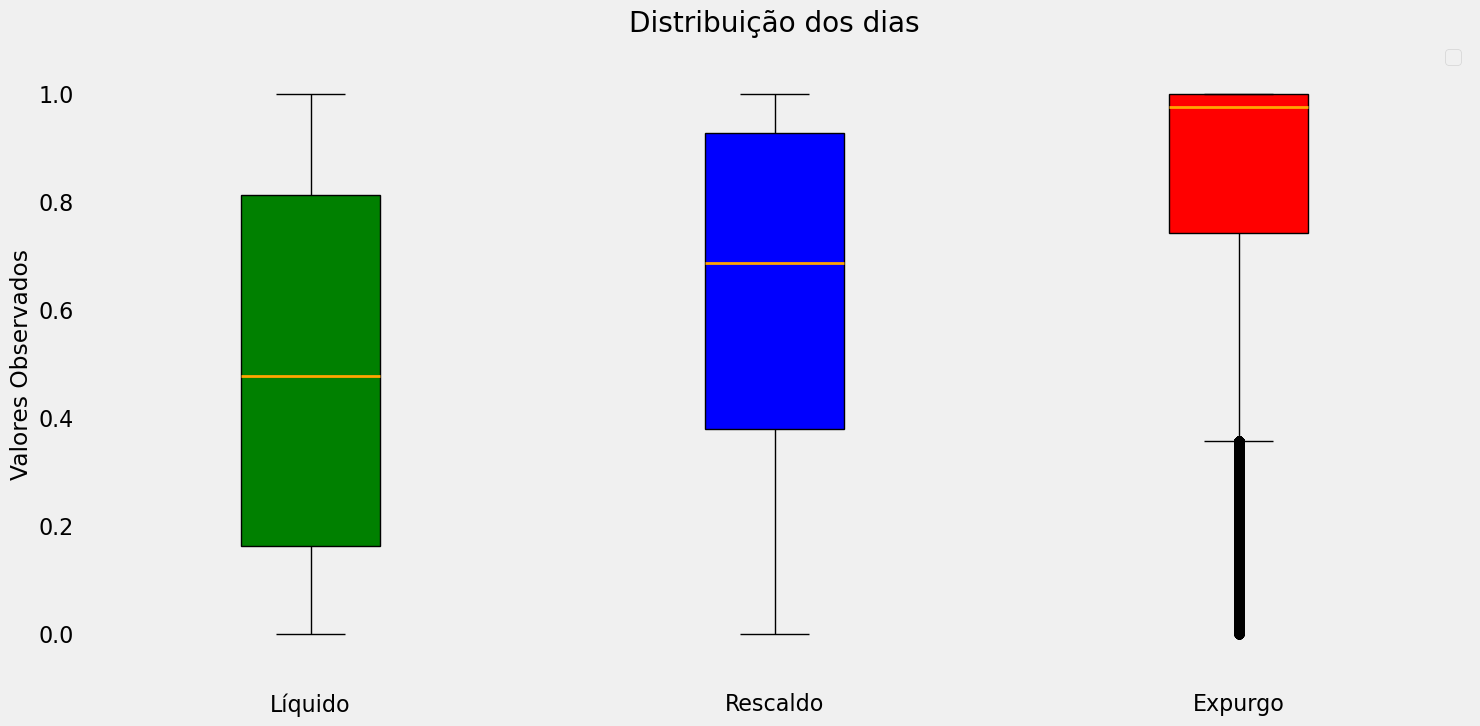

In [645]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize=(16,8))

bplot1 = ax.boxplot([df_sum_liq, df_sum_res, df_sum_exp], patch_artist=True, labels=['Líquido', 'Rescaldo','Expurgo'])

colors = ['green', 'blue', 'red']

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

for median in bplot1['medians']:
    median.set_color('orange')
    median.set_linewidth(2)

ax.set_ylim([-0.1,1.1])
ax.legend()
ax.set_ylabel('Valores Observados')
ax.set_title('Distribuição dos dias')

ax.grid(False)
# ax.set_title('168)
# ax.set_xlabel('Região')
plt.savefig('rescaldo_boxplot.png', transparent=True)

## Kolmogorov–Smirnov test

In [201]:
from scipy.stats import ks_2samp, kstest

In [232]:
ks_2samp(df_sum_liq, df_sum_res)

KstestResult(statistic=0.17944023870683373, pvalue=0.0, statistic_location=0.4719070603381508, statistic_sign=1)

In [231]:
ks_2samp(df_sum_liq, df_sum_exp)

KstestResult(statistic=0.45102430178296005, pvalue=0.0, statistic_location=0.786701594968452, statistic_sign=1)

In [230]:
kstest(df_sum_res, df_sum_exp)

KstestResult(statistic=0.3332288852589349, pvalue=0.0, statistic_location=0.9087959352422432, statistic_sign=1)

# Exemplo da rotulação dos Dias

In [600]:
df_sumchi_dias_cea = df_sumchi_dias_full.filter((pl.col('SigAgente') == 'LIGHT') &
                                               (pl.col('IdeConjuntoUnidadeConsumidora') == 15000) &
                                               (pl.col('DatInicioInterrupcao_date').is_between(date(2022,12,28), date(2023,4,7)))
                                              )

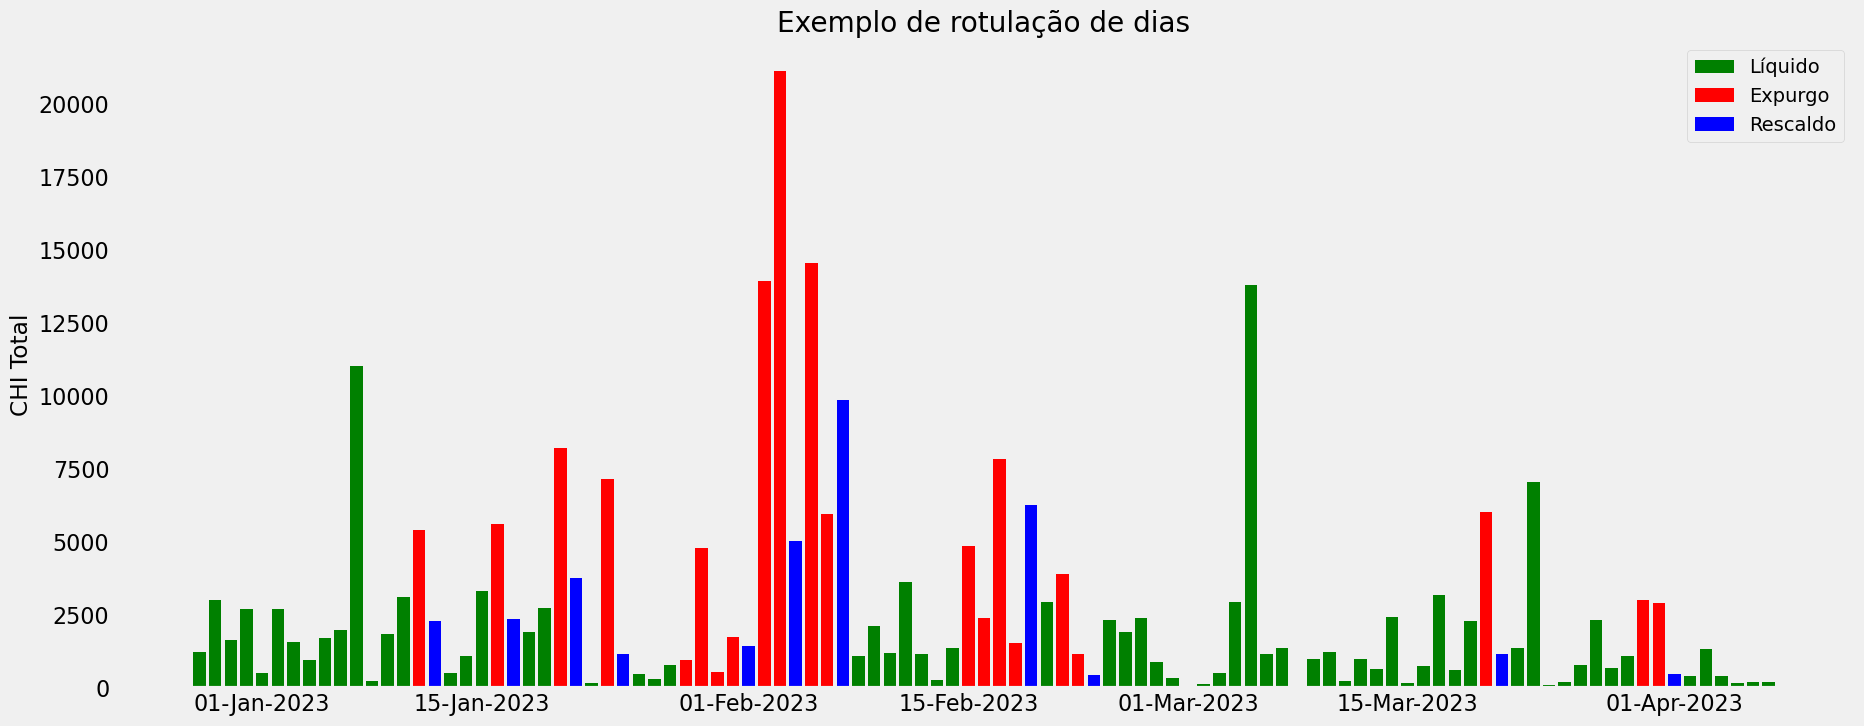

In [656]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(1,1, figsize=(20,8))

df_sum_liq = df_sumchi_dias_cea.filter(pl.col('tipo') == 'liq')
df_sum_res = df_sumchi_dias_cea.filter(pl.col('tipo') == 'res')
df_sum_exp = df_sumchi_dias_cea.filter(pl.col('tipo') == 'exp')

ax.bar(df_sum_liq['DatInicioInterrupcao_date'], df_sum_liq['chi_tot'], color='green', label='Líquido')
ax.bar(df_sum_exp['DatInicioInterrupcao_date'], df_sum_exp['chi_tot'], color='red',  label='Expurgo')
ax.bar(df_sum_res['DatInicioInterrupcao_date'], df_sum_res['chi_tot'], color='blue', label='Rescaldo')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))

ax.legend()
ax.set_ylabel('CHI Total')
ax.grid(False)
ax.set_title('Exemplo de rotulação de dias')
# ax.set_xlabel('Região')
plt.savefig('rescaldo_exemplo_dias.png', transparent=True)
plt.show()

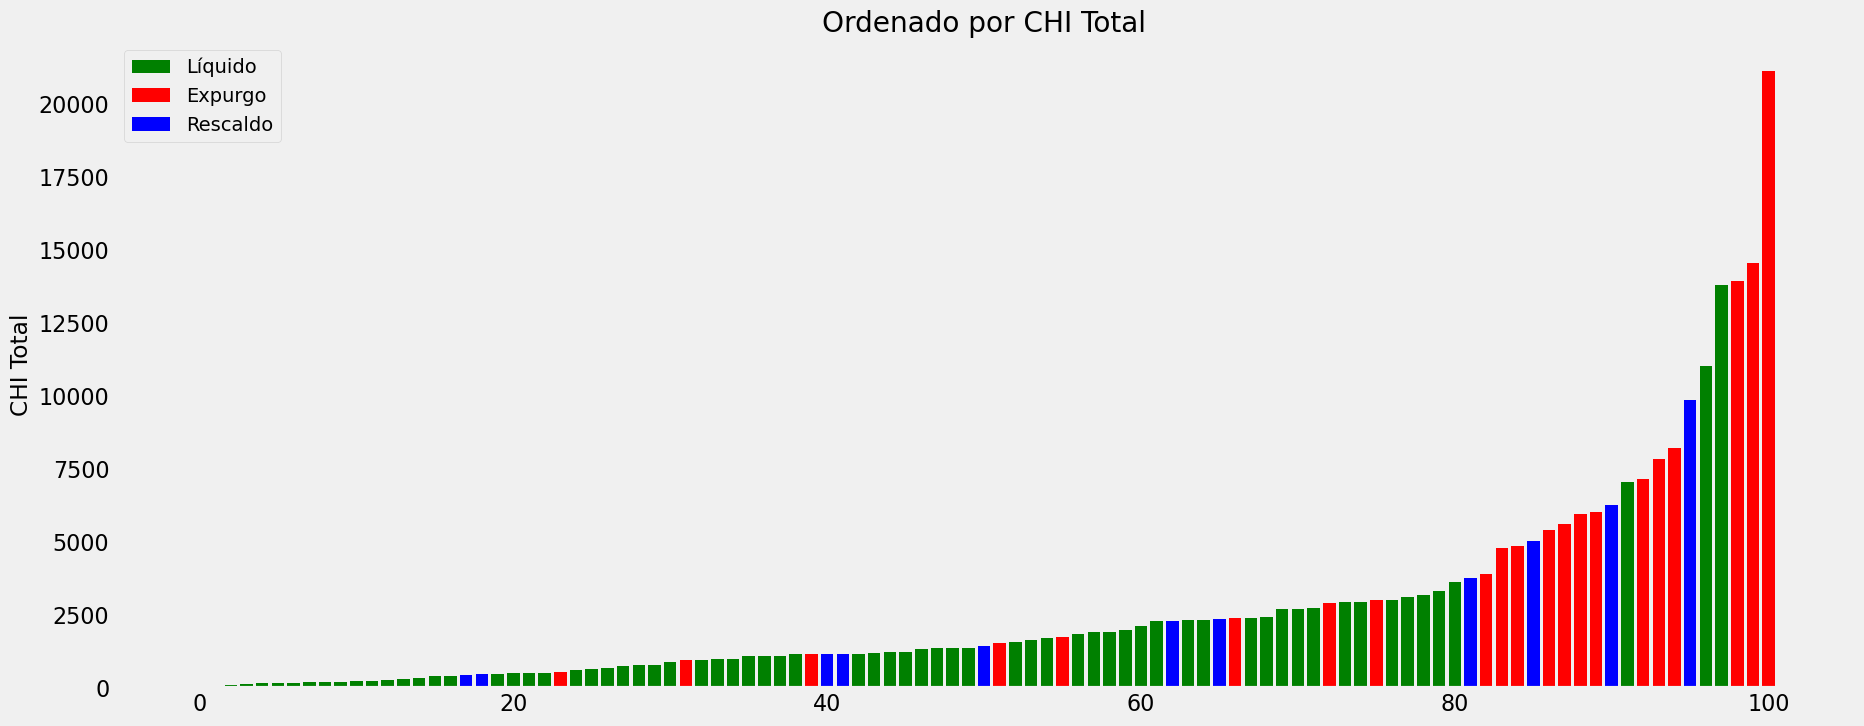

In [657]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(20,8))

# Cria uma coluna de ordenacao
df_sumchi_dias_cea_sorted = df_sumchi_dias_cea.sort(by='chi_tot').with_columns(idx = pl.int_range(pl.len()))

df_sum_liq_sorted = df_sumchi_dias_cea_sorted.filter(pl.col('tipo') == 'liq')
df_sum_res_sorted = df_sumchi_dias_cea_sorted.filter(pl.col('tipo') == 'res')
df_sum_exp_sorted = df_sumchi_dias_cea_sorted.filter(pl.col('tipo') == 'exp')

ax.bar(df_sum_liq_sorted['idx'], df_sum_liq_sorted['chi_tot'], color='green', label='Líquido')
ax.bar(df_sum_exp_sorted['idx'], df_sum_exp_sorted['chi_tot'], color='red',  label='Expurgo')
ax.bar(df_sum_res_sorted['idx'], df_sum_res_sorted['chi_tot'], color='blue', label='Rescaldo')


ax.legend()
ax.set_ylabel('CHI Total')
ax.grid(False)
ax.set_title('Ordenado por CHI Total')
# ax.set_xlabel('Região')
plt.savefig('rescaldo_exemplo_dias_ordenado.png', transparent=True)
plt.show()

# Impacto do Rescaldo

## Impacto por ano

In [517]:
df_chi_tipo_anos = df_sumchi_dias.group_by(['tipo', pl.col('DatInicioInterrupcao_date').dt.year()]).agg(chi=pl.sum('chi_tot')/10**6).sort(by='DatInicioInterrupcao_date').collect()#.to_pandas()

In [518]:
df_chi_tipo_anos = df_chi_tipo_anos.with_columns(total_chi = pl.sum('chi').over('DatInicioInterrupcao_date'))
df_chi_tipo_anos = df_chi_tipo_anos.with_columns(perc = pl.col('chi') / pl.col('total_chi')*100)
df_chi_tipo_anos = df_chi_tipo_anos.to_pandas()

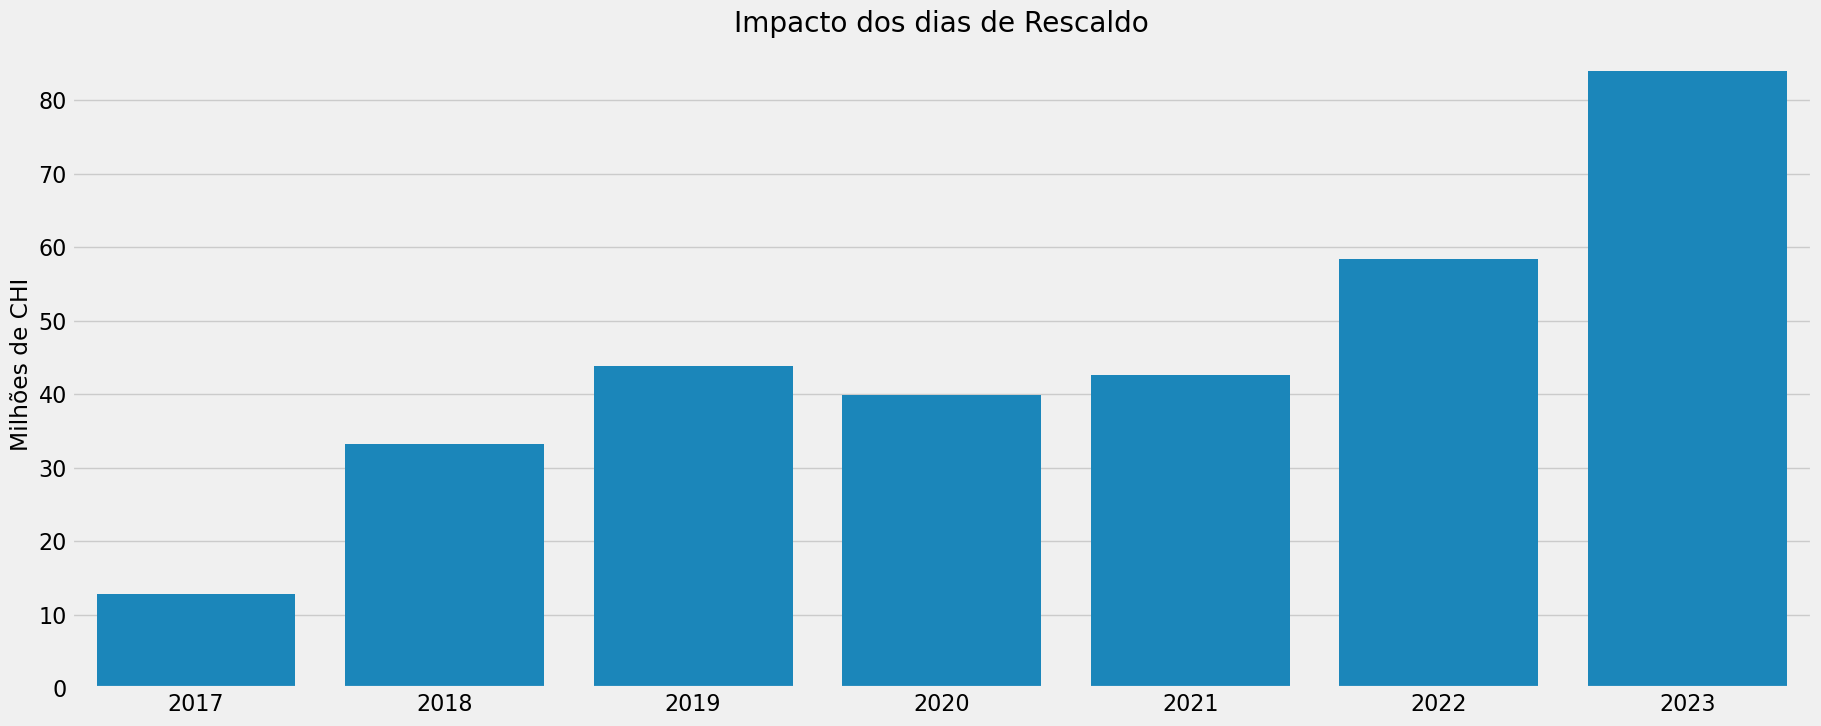

In [652]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax = sns.barplot(df_chi_tipo_anos.query("(tipo == 'res') & (DatInicioInterrupcao_date != 2024)"), x='DatInicioInterrupcao_date', y='chi', hue='tipo', legend=False)
ax.set_ylabel('Milhões de CHI')
ax.set_title('Impacto dos dias de Rescaldo')
ax.set_xlabel('')

plt.savefig('rescaldo_impacto_ano.png', transparent=True)
plt.show()

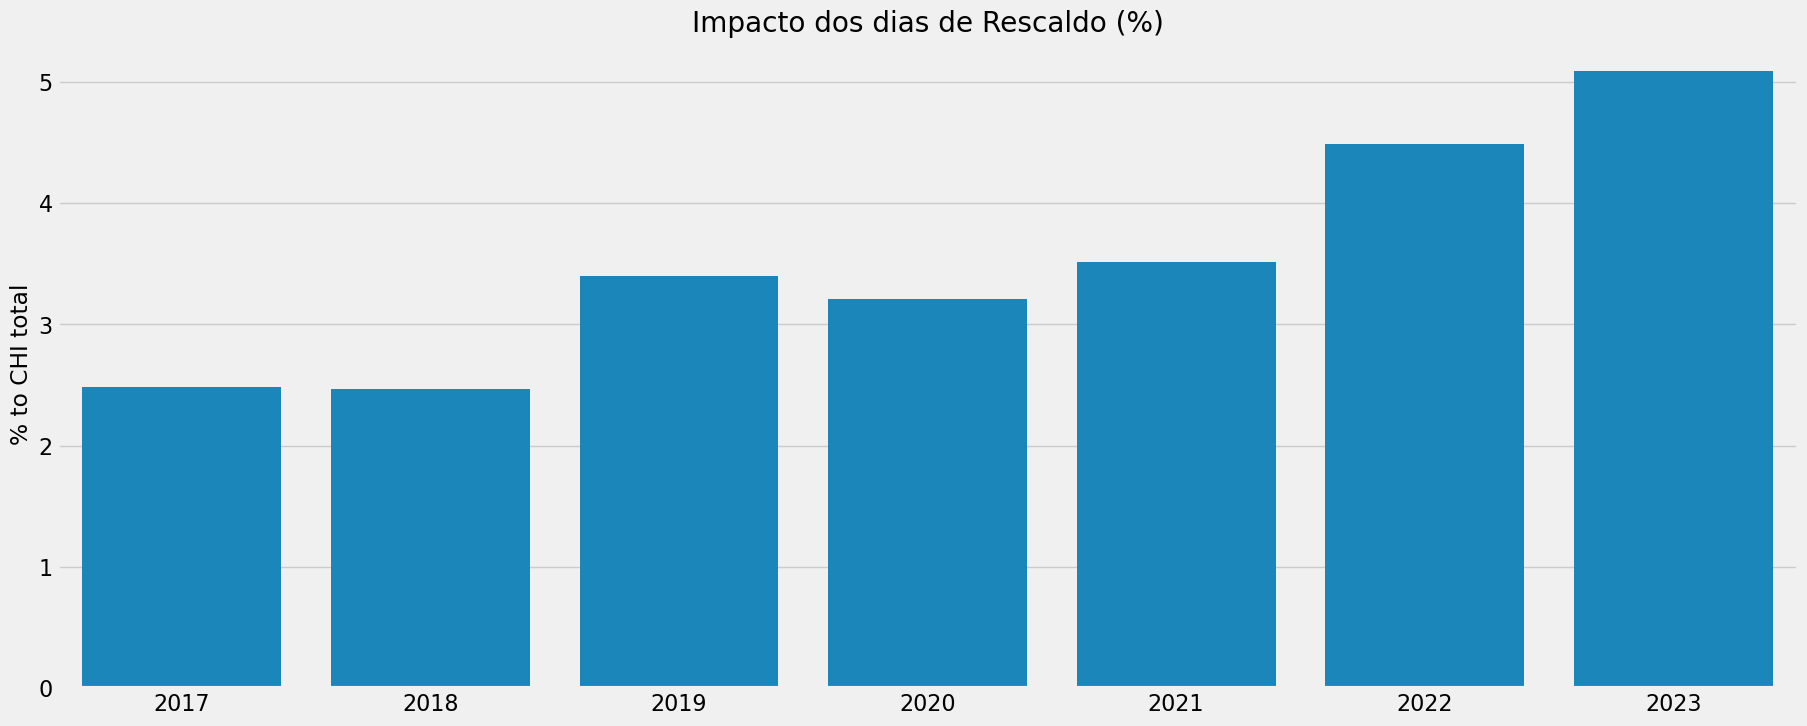

In [653]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax = sns.barplot(df_chi_tipo_anos.query("(tipo == 'res') & (DatInicioInterrupcao_date != 2024)"), x='DatInicioInterrupcao_date', y='perc', legend=False)
ax.set_ylabel('% to CHI total')
ax.set_title('Impacto dos dias de Rescaldo (%)')
ax.set_xlabel('')

plt.savefig('rescaldo_impacto_ano_perc.png', transparent=True)
plt.show()

# Impacto por Agente

In [521]:
df_chi_tipo_2023 = df_sumchi_dias.filter((pl.col('DatInicioInterrupcao_date').dt.year() == 2023)
                                       ).group_by(['tipo', 'SigAgente']).agg(chi=pl.sum('chi_tot')/10**6).sort(by='chi', descending=True).collect()

In [522]:
df_chi_tipo_2023 = df_chi_tipo_2023.with_columns(total_chi = pl.sum('chi').over('SigAgente'))
df_chi_tipo_2023 = df_chi_tipo_2023.with_columns(perc = pl.col('chi') / pl.col('total_chi')*100)
df_chi_tipo_2023 = df_chi_tipo_2023.to_pandas()
df_chi_tipo_2023.head()

tipo    SigAgente                  chi            total_chi                 perc
0  exp  ELETROPAULO                95.88               143.94                66.61
1  exp      CEMIG-D                74.70               158.59                47.10
2  exp       CEEE-D                73.22               104.90                69.80
3  liq       COELBA                72.72                98.64                73.72
4  liq      CEMIG-D                72.15               158.59                45.49

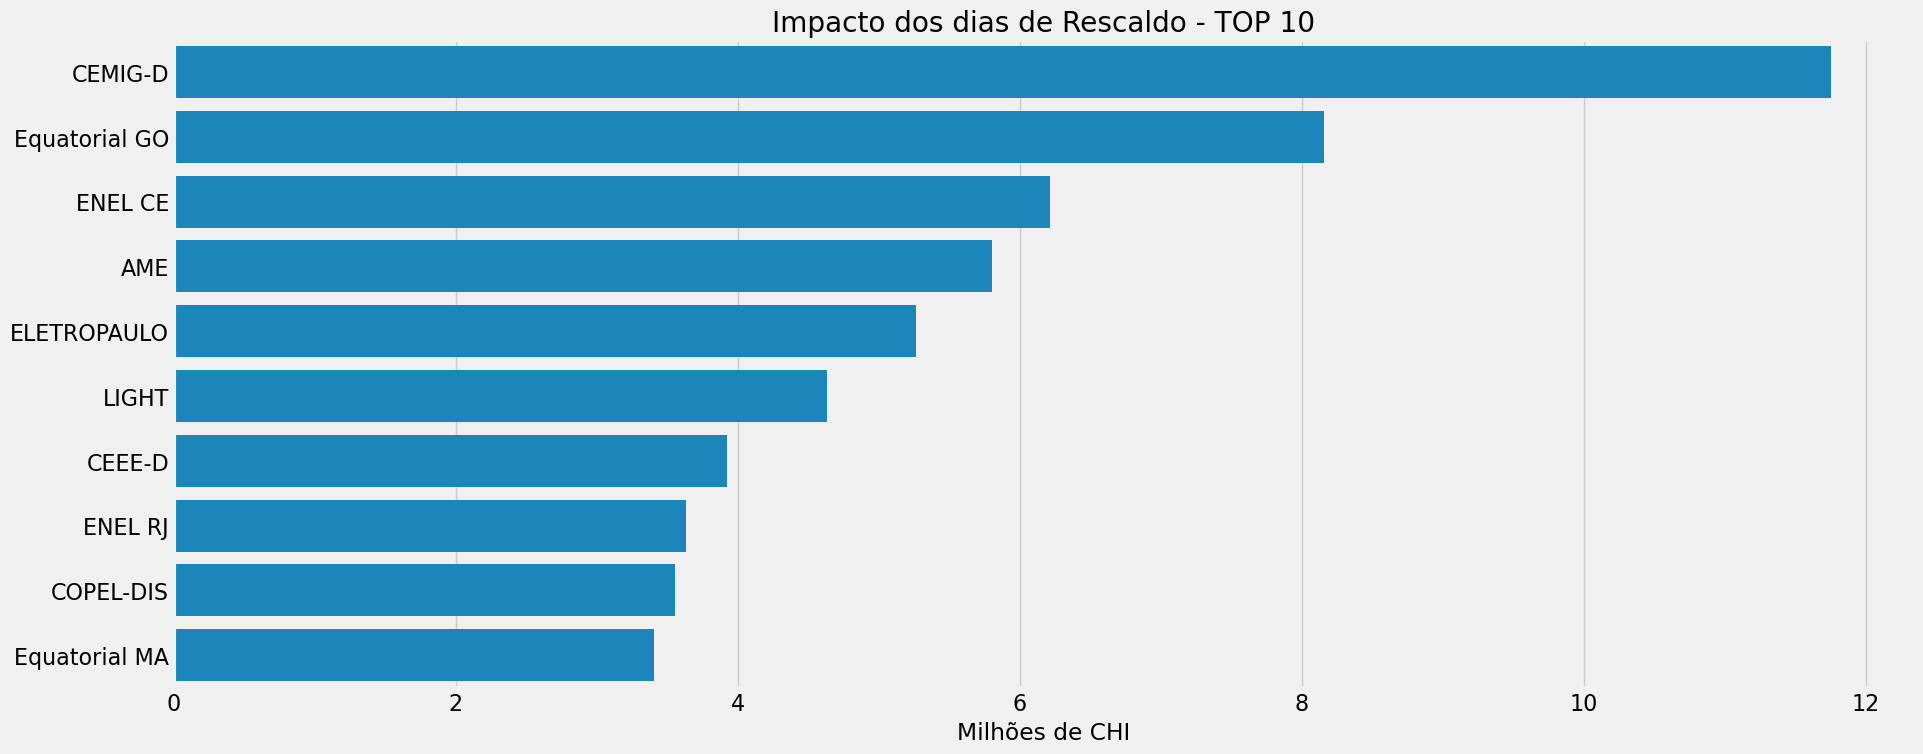

In [651]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax = sns.barplot(df_chi_tipo_2023.query("(tipo == 'res')").sort_values(by='chi', ascending=False).head(10), y='SigAgente', x='chi', legend=False)
ax.set_xlabel('Milhões de CHI')
ax.set_title('Impacto dos dias de Rescaldo - TOP 10')
ax.set_ylabel('')

plt.savefig('rescaldo_impacto_agente.png', transparent=True)
plt.show()

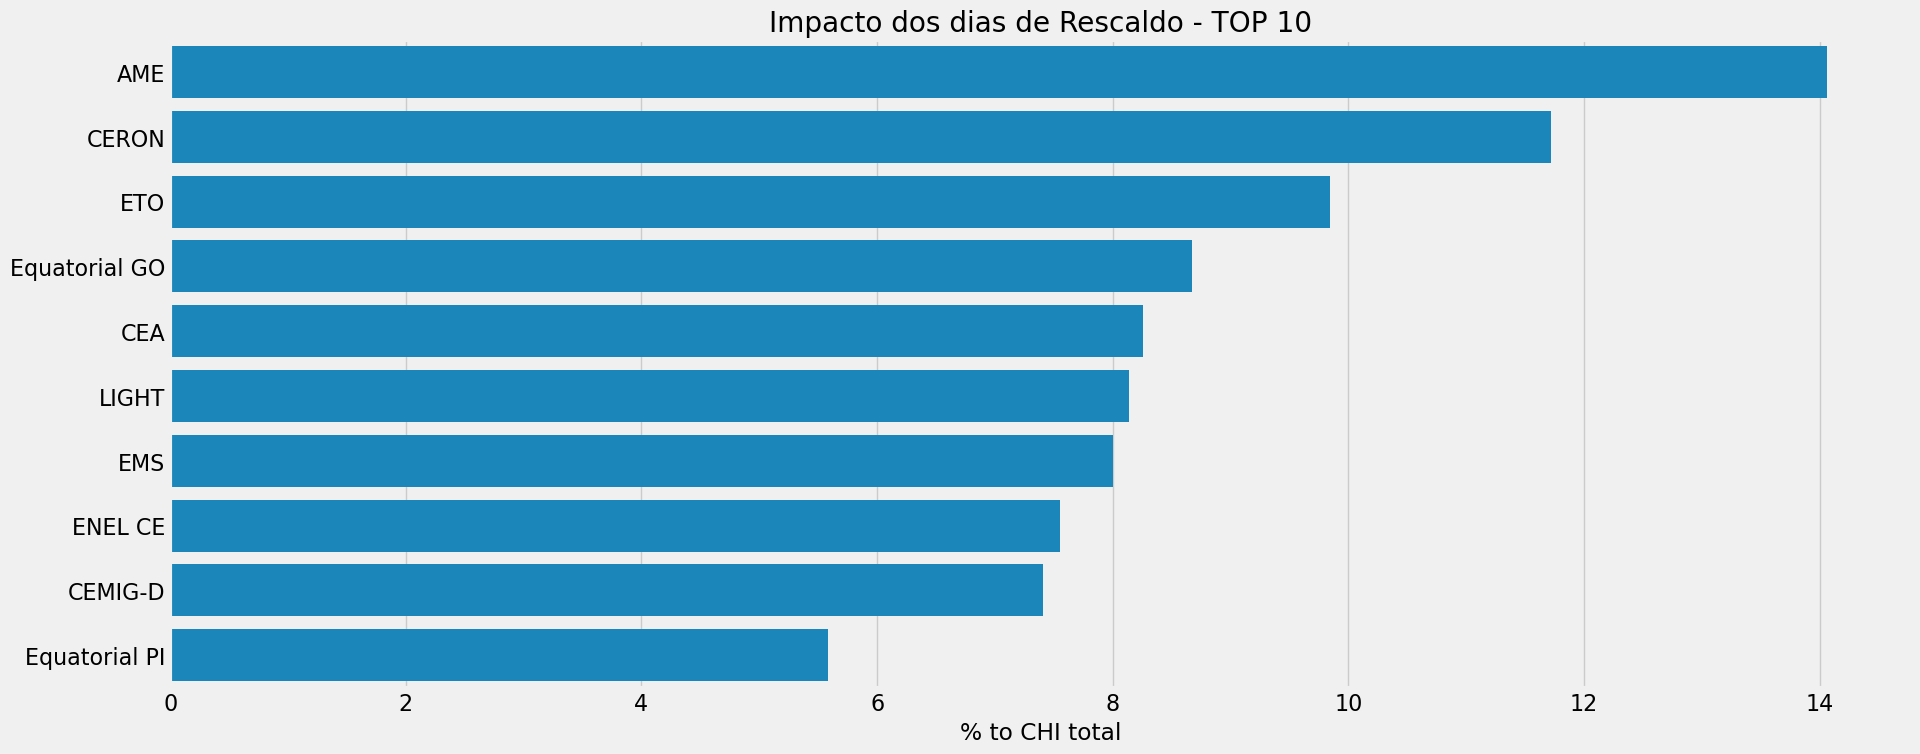

In [650]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax = sns.barplot(df_chi_tipo_2023.query("(tipo == 'res')").sort_values(by='perc', ascending=False).head(10), y='SigAgente', x='perc', legend=False)
ax.set_xlabel('% to CHI total')
ax.set_title('Impacto dos dias de Rescaldo - TOP 10')
ax.set_ylabel('')

plt.savefig('rescaldo_impacto_agente_perc.png', transparent=True)
plt.show()